### Notebook to create the simplified FOM producer for cluster implementation

In [73]:
%load_ext autoreload

%autoreload 2

In [76]:
# import stuff
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers

import core.functions as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from core.functions import plot_fit as plot_fit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

In [2]:
# load in data for merging
folder_paths = ['75_9e-3/PORT_1a/isaura/', '75_9e-3/PORT_1b/isaura/', '75_9e-3/PORT_2a/isaura/']
full_tracks = func.collate_ports(folder_paths)

# apply cuts, SATELLITE TRACKS ARE DIFFERENT RN
#low_e_tracks = func.remove_low_E_events(full_tracks)
low_e_tracks = full_tracks[full_tracks.energy > 0.05]
cut_tracks = func.apply_cuts(low_e_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)


Porting 75_9e-3/PORT_1a/isaura/
50
100
150
200
250
300
Done! Tracks available: 87009
Porting 75_9e-3/PORT_1b/isaura/
50
100
150
200
250
300
Tracks: 84703
Done! Tracks available: 152826
Porting 75_9e-3/PORT_2a/isaura/
50
100
150
200
250
300
Tracks: 60529
Done! Tracks available: 198973
Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 40.72 %
Absolute Cut efficiency:
Efficiency: 40.72 %
One track cut
Relative Cut efficiency:
Efficiency: 64.68 %
Absolute Cut efficiency:
Efficiency: 53.24 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 72.56 %
Absolute Cut efficiency:
Efficiency: 71.49 %
Energy cut
Relative Cut efficiency:
Efficiency: 10.75 %
Absolute Cut efficiency:
Efficiency: 7.61 %


In [3]:
# find positron events per port
pos_events = func.positron_ports(folder_paths)

Loading positrons from 75_9e-3/PORT_1a/isaura/
Port finished! Tracks available: 13282
Loading positrons from 75_9e-3/PORT_1b/isaura/
Positron events: 12865
Port finished! Tracks available: 25717
Loading positrons from 75_9e-3/PORT_2a/isaura/
Positron events: 9663
Port finished! Tracks available: 34976


In [79]:
def histogram_fit(fnc, sig_data, binning, p0, fit_labels, bounds = []):
    '''
    fit a function from histogram data, return the fitting parameters
    '''


    # Use positron data to collect the C1 and C2 values from the signal fit
    s_cnts, s_edges, s_patches = func.plot_hist(sig_data, binning = binning, log = False, data = True)

    
    s_centres = shift_to_bin_centers(s_edges)

    # FIT
    if (bounds == []):
        return curve_fit(fnc, s_centres, s_cnts, p0, maxfev = 500000)
    else:
        return curve_fit(fnc, s_centres, s_cnts, p0, maxfev = 500000, bounds = bounds)

def fom_calc_MC(cut_data, positron_data, cut_list, binning = 80, verbose = False):
    '''
        calculate FOM via fitting using MC information for C1 and C2
        start the cut list at non-zero. eg cut_list = [0.1, 0.2, ...]
    '''
    # preset some parameters for sanity purposes
    emin = 1.5
    emax = 1.7


    # select only events in which events have positrons
    sig_data = cut_data[cut_data['event'].isin(positron_data['event_id'].to_numpy())]
    bck_data = cut_data[~cut_data['event'].isin(positron_data['event_id'].to_numpy())]


    print("Obtaining C1 and C2")
    #####            C1 AND C2 ACQUISITION          #####
    # p0 is apriori
    p0 = ([1, 1, 1.58, 0.3, 0.8, 0])
    fit_labels = ['B1', 'A', 'mu', 'sigma', 'C1', 'C2']
    
    # fit the histogram
    s_popt, s_pcov = histogram_fit(func.sig_func, sig_data, binning, p0, fit_labels)

    
    if (verbose == True):
        print("=========================== SIGNAL FIT ============================")
        func.plot_fit(func.sig_func, np.linspace(emin, emax, 1000), s_popt, fit_labels)
        func.plot_hist(sig_data, binning = 80, title='Signal fit', log = False)
        plt.show()
        func.print_parameters(s_popt, s_pcov, fit_labels)
    
    # Set C1 and C2
    C1 = s_popt[4]
    C2 = s_popt[5]

    # C1 and C2 control
    if (C1 < 0):
        C1 = 0
    if (C2 < 0):
        C2 = 0

    print("C1: {}, C2: {}".format(C1, C2))



    #####           MU AND SIGMA ACQUISITION            #####

    # apriori
    g_p0 = [500, 1.6, 0.01]
    g_labels = ['A', 'mu', 'sigma']

    # collect histogram information

    #cnt, edges, patches = func.plot_hist(cut_data, binning = binning, log = False, data = True)
    # fit
    #g_popt, g_pcov = curve_fit(func.gauss, centres, cnts, g_p0, maxfev = 500000)
    g_popt, g_pcov = histogram_fit(func.gauss, cut_data, binning, g_p0, g_labels)
    # set mu and sigma
    mu      = g_popt[1]
    sigma   = g_popt[2]

    print("mu: {}, sigma: {}".format(mu, sigma))

    if (verbose == True):
        print("=========================== GAUSSIAN FIT ============================")
        func.plot_fit(func.gauss, np.linspace(emin, emax, 1000), g_popt, g_labels)
        func.plot_hist(cut_data, binning = 80, title='Gauss fit', log = False)
        plt.show()
        func.print_parameters(g_popt, g_pcov, g_labels)


    #####          NS AND NB ACQUISITION                #####

    fixed_sig_bck_func = lambda x, ns, a, nb, tau: func.sig_bck_func(x, ns, a, mu, sigma, C1, C2, nb, tau)

    # apriori
    sb_p0 = [400, 1, 20, 0.1]
    sb_labels = ['ns', 'a', 'nb', 'tau']

    # fit
    sb_popt, sb_pcov = histogram_fit(fixed_sig_bck_func, cut_data, binning, sb_p0, sb_labels)
    #sb_popt, sb_pcov = curve_fit(fixed_sig_bck_func, centres, cnts, sb_p0, maxfev = 500000)
    # take bin widths to calculate number of events
    _, edges, _ =func.plot_hist(cut_data, binning = binning, log = False, data = True)
    bin_width = edges[1] - edges[0]
    ns0 = quad(func.sig_func, emin, emax, args = (sb_popt[0],sb_popt[1], mu, sigma, C1, C2))/bin_width
    nb0 = quad(func.bck_func, emin, emax, args = (sb_popt[2], sb_popt[3]))/bin_width

    if (verbose == True):

        print("=========================== FULL FIT ============================")
        func.plot_fit(fixed_sig_bck_func, np.linspace(emin, emax, 1000), sb_popt, sb_labels)
        func.plot_hist(cut_data, binning = 80, title='Full fit', log = False)
        plt.show()
        func.print_parameters(sb_popt, sb_pcov, sb_labels)

        print('ns0      = {}'.format(ns0[0]))
        print('nb0      = {}'.format(nb0[0]))
        print("total    = {:.0f}".format(ns0[0]+nb0[0]))
        print("Event no = {}".format(len(cut_data.index)))
    
    
    # create list for fom values
    e       = []
    b       = []
    ns_l      = []
    nb_l      = []
    fom     = []
    fom_err = []
    e_err = []
    b_err = []

    ns_l.append(ns0[0])
    nb_l.append(nb0[0])

    # wipe variables to stop variable bleed over
    del g_popt, g_pcov, mu, sigma, sb_popt, sb_pcov, bin_width

    if (verbose == True):
        print("=========================== ====================== ===========================")
        print("=========================== BLOB 2 CUT STARTS HERE ===========================")
        print("=========================== ====================== ===========================")

    for i in range(len(cut_list)):

        print("Applying cut {} MeV".format(cut_list[i]))

        blob_data = cut_data[(cut_data['eblob2'] > cut_list[i])]

        # collect gaussian peak
        g_popt, g_pcov = histogram_fit(func.gauss, blob_data, binning, g_p0, g_labels)
        # set mu and sigma
        mu      = g_popt[1]
        sigma   = g_popt[2]

        if (verbose == True):
            print("=========================== GAUSSIAN FIT ============================")
            func.plot_fit(func.gauss, np.linspace(emin, emax, 1000), g_popt, g_labels)
            func.plot_hist(blob_data, binning = 80, title='Gauss fit', log = False)
            plt.show()
            func.print_parameters(g_popt, g_pcov, g_labels)


        # collect nb and ns
        sb_popt, sb_pcov = histogram_fit(fixed_sig_bck_func, blob_data, binning, sb_p0, sb_labels, bounds = ([0, -np.inf, 0, -np.inf],[np.inf, np.inf, np.inf, np.inf]))
        # take bin widths to calculate number of events
        _, edges, _ =func.plot_hist(blob_data, binning = binning, log = False, data = True, output = False)
        bin_width = edges[1] - edges[0]
        ns = quad(func.sig_func, emin, emax, args = (sb_popt[0],sb_popt[1], mu, sigma, C1, C2))/bin_width
        nb = quad(func.bck_func, emin, emax, args = (sb_popt[2], sb_popt[3]))/bin_width
        ns_l.append(ns[0])
        nb_l.append(nb[0])
        if (verbose == True):

            print("=========================== FULL FIT ============================")
            plt.clf()
            func.plot_fit(fixed_sig_bck_func, np.linspace(emin, emax, 1000), sb_popt, sb_labels, lgnd='Full fit')
            func.plot_fit(func.bck_func, np.linspace(emin, emax, 1000), sb_popt[-2:], sb_labels[-2:], lgnd='Background fit', colour = 'yellow')#, linestyle = 'dashed')

            # collect all sb_vales
            s_popt = [sb_popt[0], sb_popt[1], mu, sigma, C1, C2]
            s_labels = ['ns', 'a', 'mu', 'sigma', 'C1', 'C2']
            func.plot_fit(func.sig_func, np.linspace(emin, emax, 1000), s_popt, s_labels, lgnd='Signal fit', colour= 'green')#, linestyle = 'dashed')
            
            
            func.plot_hist(blob_data, binning = 80, title='Full fit', log = False, label = 'Data')
            plt.legend()
            plt.show()
            func.print_parameters(sb_popt, sb_pcov, sb_labels)

            print('ns - {}'.format(ns[0]))
            print('nb - {}'.format(nb[0]))
            print("total = {:.0f}".format(ns[0]+nb[0]))
            print("Event no = {}".format(len(blob_data.index)))
        
        e_check = ns[0]/ns0[0]
        b_check = nb[0]/nb0[0]
        fom_check = e_check/np.sqrt(b_check)

        e.append(e_check)
        b.append(b_check)
        fom.append(fom_check)

        # errors for fom
        e_err.append(func.ratio_error(e[i],ns[0],ns0[0],np.sqrt(ns[0]),np.sqrt(ns0[0])))
        b_err.append(func.ratio_error(b[i],nb[0],nb0[0],np.sqrt(nb[0]),np.sqrt(nb0[0])))
        fom_err.append(func.fom_error(e[i], b[i], e_err[i], b_err[i]))

        if (verbose == True):
            print('fom - {:.2f} ± {:.2f}'.format(fom_check, fom_err[i]))
            print('e - {:.2f} ± {:.2f}'.format(e_check, e_err[i]))
            print('b - {:.2f} ± {:.2f}'.format(b_check, b_err[i]))

        # wipe variables here
        del blob_data, g_popt, g_pcov, mu, sigma, sb_popt, sb_pcov, ns, nb, bin_width, e_check, b_check, fom_check
    
    return (fom, fom_err, ns_l, nb_l)



In [5]:
cut_list = np.linspace(0,0.6, 61)
print(cut_list)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6 ]


Obtaining C1 and C2
=========================== SIGNAL FIT ============================


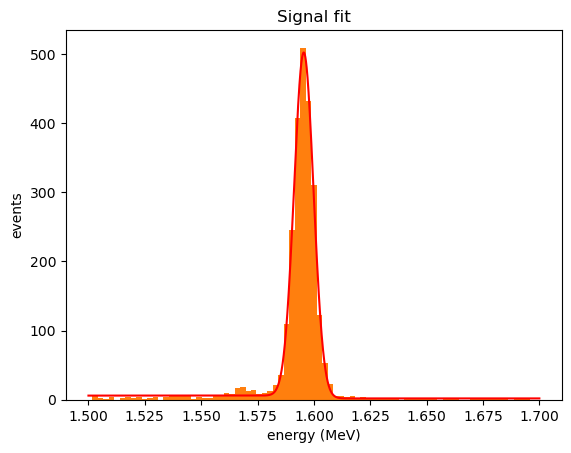

        Fitting output      
B1: 5.3794 ± 1.9020
A: 0.0176 ± 136.1038
mu: 1.5955 ± 0.4677
sigma: 0.0043 ± 0.0079
C1: 0.3779 ± 0.1569
C2: 0.3520 ± 0.2115
C1: 0.37792968058787235, C2: 0.3519561034730971
mu: 1.5954169538727059, sigma: 0.004595281255864209
=========================== GAUSSIAN FIT ============================


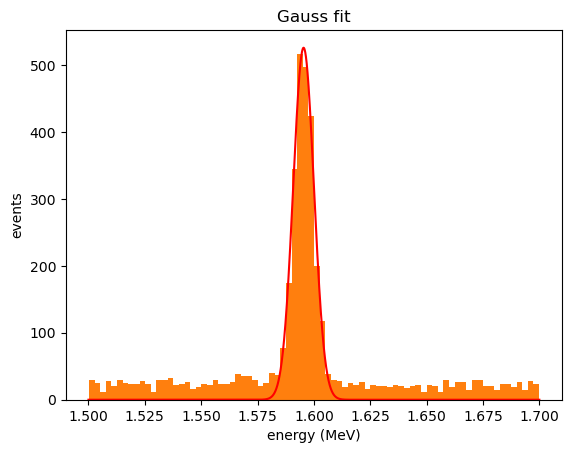

        Fitting output      
A: 525.6724 ± 16.2472
mu: 1.5954 ± 0.0002
sigma: 0.0046 ± 0.0002
=========================== FULL FIT ============================


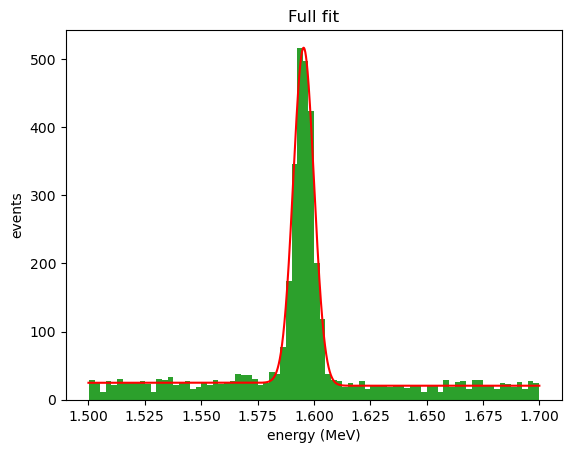

        Fitting output      
ns: 5.6850 ± 0.0620
a: 0.0087 ± 0.0184
nb: 18.5504 ± 28.2010
tau: 778825.2358 ± 311921962959.5612
ns0      = 2602.6364349512705
nb0      = 1486.627221175132
total    = 4089
Event no = 4086
=========================== ====================== ===========================
=========================== BLOB 2 CUT STARTS HERE ===========================
=========================== ====================== ===========================
Applying cut 0.1 MeV
=========================== GAUSSIAN FIT ============================


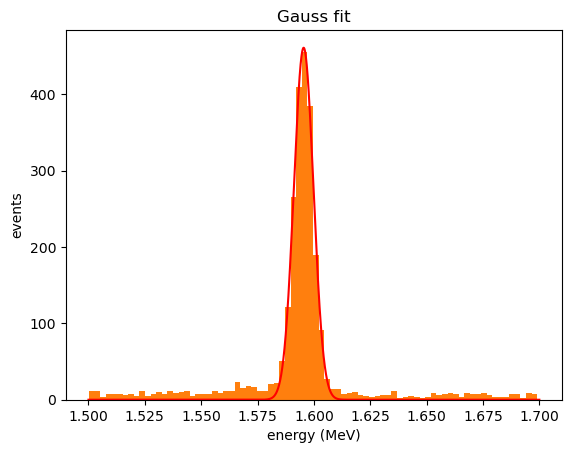

        Fitting output      
A: 461.0978 ± 6.5797
mu: 1.5954 ± 0.0001
sigma: 0.0043 ± 0.0001
=========================== FULL FIT ============================


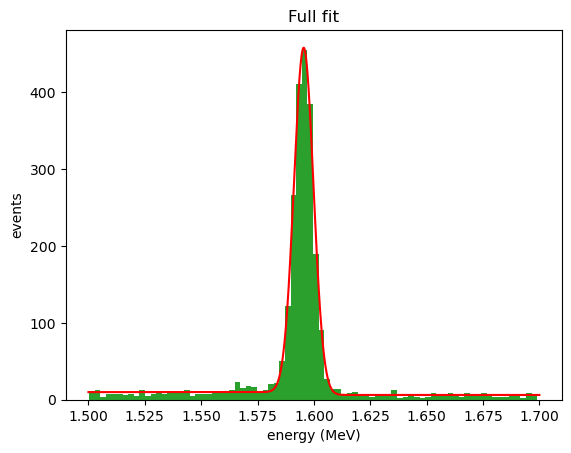

        Fitting output      
ns: 4.8795 ± 0.0320
a: 0.0082 ± 0.0114
nb: 4.4848 ± 15.3797
tau: 182938.6191 ± 71655867506.3930
ns - 2243.3730541093246
nb - 360.93457651082406
total = 2604
Event no = 2601
=========================== ====================== ===========================
=========================== BLOB 2 CUT STARTS HERE ===========================
=========================== ====================== ===========================
Applying cut 0.2 MeV
=========================== GAUSSIAN FIT ============================


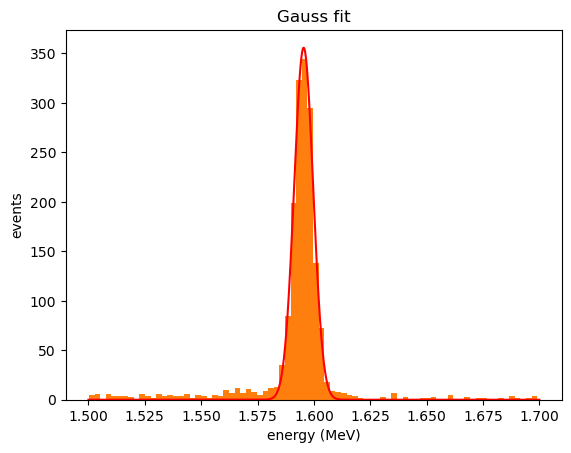

        Fitting output      
A: 355.8036 ± 4.0095
mu: 1.5954 ± 0.0001
sigma: 0.0042 ± 0.0001
=========================== FULL FIT ============================


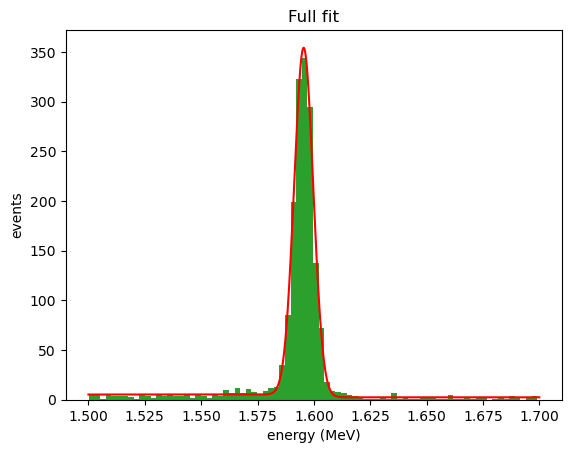

        Fitting output      
ns: 3.7122 ± 0.0262
a: 0.0080 ± 0.0125
nb: 1.1146 ± 11.8498
tau: 87437.8174 ± 50754864630.5159
ns - 1706.7113301884644
nb - 89.70223084731454
total = 1796
Event no = 1795
=========================== ====================== ===========================
=========================== BLOB 2 CUT STARTS HERE ===========================
=========================== ====================== ===========================
Applying cut 0.3 MeV
=========================== GAUSSIAN FIT ============================


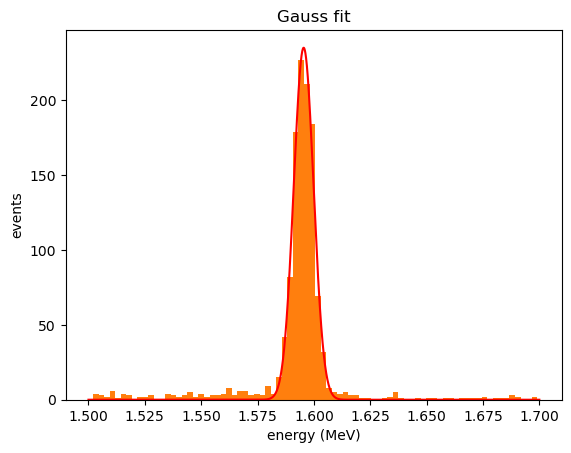

        Fitting output      
A: 235.2139 ± 3.3288
mu: 1.5955 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


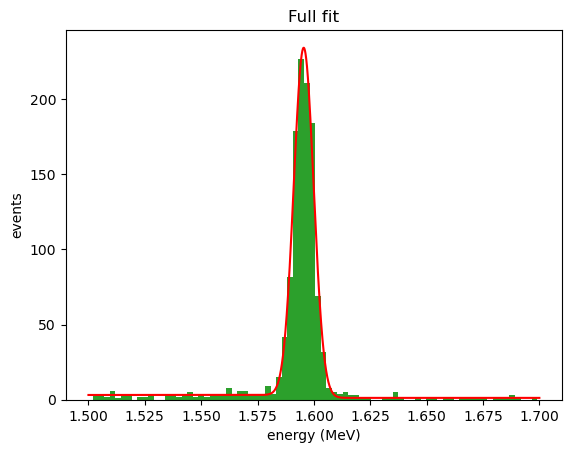

        Fitting output      
ns: 2.5625 ± 0.0276
a: 0.0083 ± 0.0183
nb: 0.3235 ± 13.4574
tau: 3648.5645 ± 345590076.1689
ns - 1188.8001497547616
nb - 26.259753890396162
total = 1215
Event no = 1212
=========================== ====================== ===========================
=========================== BLOB 2 CUT STARTS HERE ===========================
=========================== ====================== ===========================
Applying cut 0.4 MeV
=========================== GAUSSIAN FIT ============================


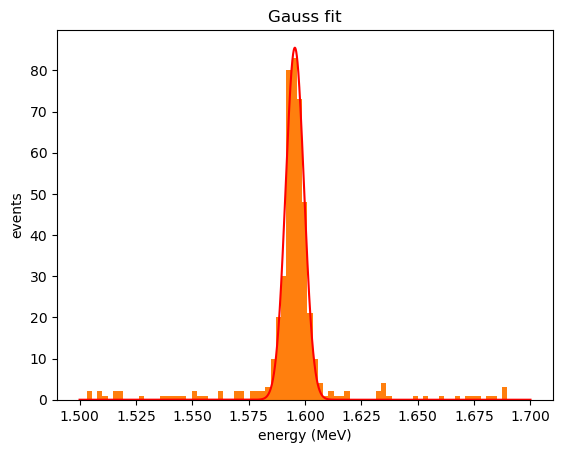

        Fitting output      
A: 85.5160 ± 1.5568
mu: 1.5955 ± 0.0001
sigma: 0.0041 ± 0.0001
=========================== FULL FIT ============================


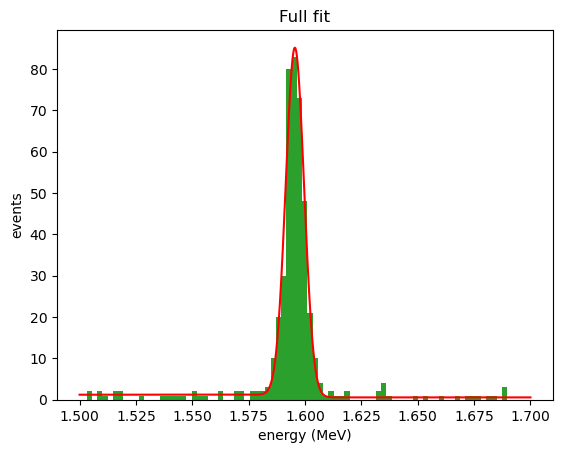

        Fitting output      
ns: 0.8591 ± 0.0126
a: 0.0077 ± 0.0251
nb: 0.2603 ± 6.5758
tau: 49591.2269 ± 38866947047.8340
ns - 420.7700763637661
nb - 22.317928173887967
total = 443
Event no = 439
=========================== ====================== ===========================
=========================== BLOB 2 CUT STARTS HERE ===========================
=========================== ====================== ===========================
Applying cut 0.5 MeV
=========================== GAUSSIAN FIT ============================


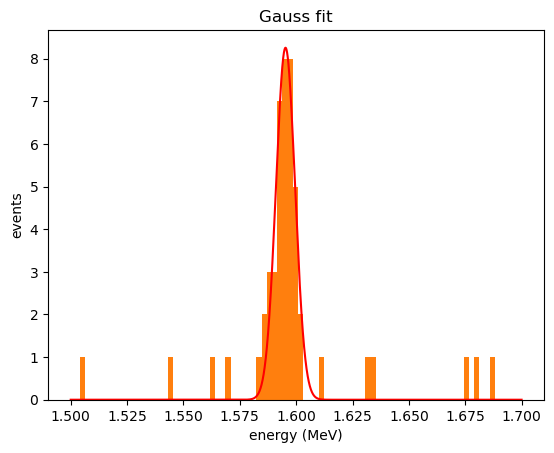

        Fitting output      
A: 8.2555 ± 0.3148
mu: 1.5953 ± 0.0002
sigma: 0.0042 ± 0.0002
=========================== FULL FIT ============================


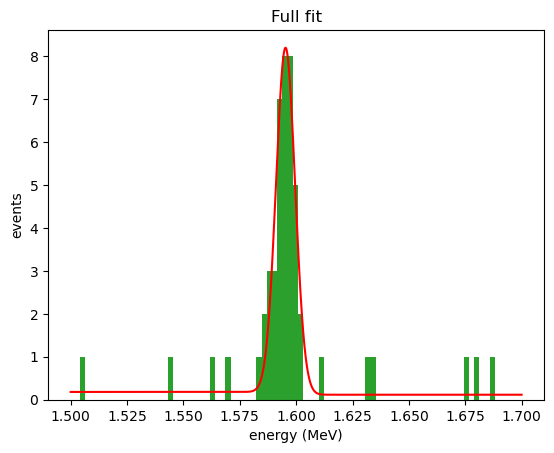

        Fitting output      
ns: 0.0854 ± 0.0027
a: 0.0080 ± 0.0542
nb: 0.0865 ± 0.0524
tau: -167153.9722 ± 0.0000
ns - 42.40710492874669
nb - 7.521517393134626
total = 50
Event no = 49
=========================== ====================== ===========================
=========================== BLOB 2 CUT STARTS HERE ===========================
=========================== ====================== ===========================
Applying cut 0.6 MeV
=========================== GAUSSIAN FIT ============================


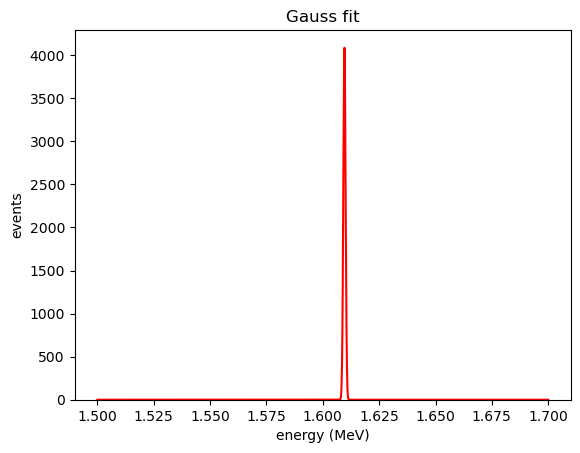

        Fitting output      
A: 4086.5779 ± nan
mu: 1.6096 ± nan
sigma: 0.0005 ± nan
=========================== FULL FIT ============================


/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1402: RuntimeWarning: invalid value encountered in sqrt
  print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors


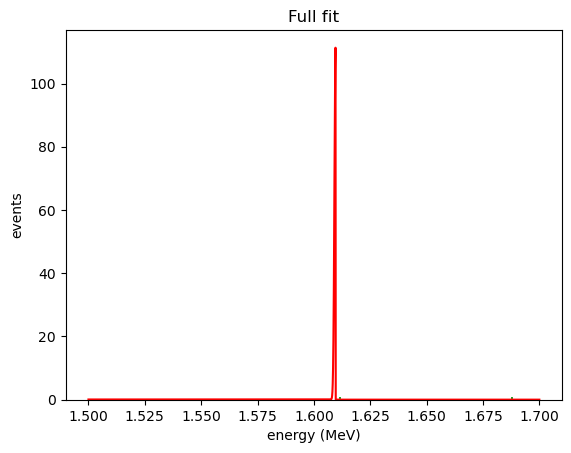

        Fitting output      
ns: 0.0710 ± 4149.3352
a: -56.2397 ± 0.0011
nb: 0.0000 ± 1420.6813
tau: 7.5685 ± 490866853.5859
ns - 85.05378950160073
nb - 0.0047057881444120975
total = 85
Event no = 2


In [76]:
cut_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
fom_out = fom_calc_MC(cut_tracks[0], pos_events, cut_list, verbose = True)

Obtaining C1 and C2
C1: 0.37792968058787235, C2: 0.3519561034730971
mu: 1.5954169538727059, sigma: 0.004595281255864209
Applying cut 0.01 MeV
Applying cut 0.02 MeV
Applying cut 0.03 MeV
Applying cut 0.04 MeV
Applying cut 0.05 MeV
Applying cut 0.060000000000000005 MeV
Applying cut 0.06999999999999999 MeV
Applying cut 0.08 MeV
Applying cut 0.09 MeV
Applying cut 0.09999999999999999 MeV
Applying cut 0.11 MeV
Applying cut 0.12 MeV
Applying cut 0.13 MeV
Applying cut 0.14 MeV
Applying cut 0.15000000000000002 MeV
Applying cut 0.16 MeV
Applying cut 0.17 MeV
Applying cut 0.18000000000000002 MeV
Applying cut 0.19 MeV
Applying cut 0.2 MeV
Applying cut 0.21000000000000002 MeV
Applying cut 0.22 MeV
Applying cut 0.23 MeV
Applying cut 0.24000000000000002 MeV
Applying cut 0.25 MeV
Applying cut 0.26 MeV
Applying cut 0.27 MeV
Applying cut 0.28 MeV
Applying cut 0.29000000000000004 MeV
Applying cut 0.3 MeV
Applying cut 0.31 MeV
Applying cut 0.32 MeV
Applying cut 0.33 MeV
Applying cut 0.34 MeV
Applying cut 

/tmp/ipykernel_12168/2566920027.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  fom_check = e_check/np.sqrt(b_check)
/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1293: RuntimeWarning: invalid value encountered in double_scalars
  f_error = f*np.sqrt((a_error/a)**2 +(b_error/b)**2)
/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1313: RuntimeWarning: divide by zero encountered in double_scalars
  element_1 = np.square(a_error/np.sqrt(b))


Applying cut 0.59 MeV
Applying cut 0.6 MeV
Applying cut 0.61 MeV


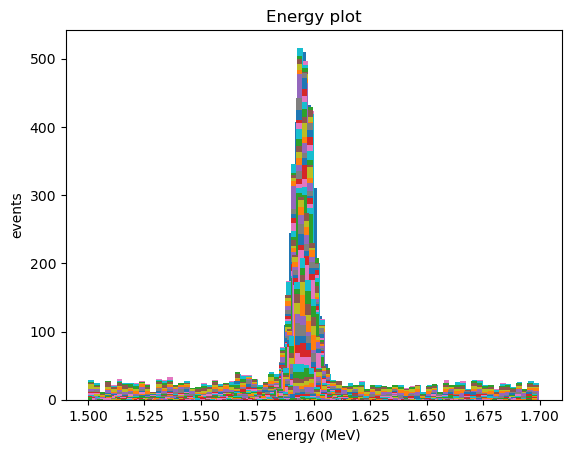

In [26]:
cut_list = np.linspace(0.01,0.61, 61)
fom_out = fom_calc_MC(cut_tracks[0], pos_events, cut_list)

In [78]:
print(fom_out)

[1.7493422692404823, 1.8223077826332161, 1.964300680974419, 2.0419731282879887, 2.1135394484402292, 2.2628363189326235, 2.4150720636442644, 2.4827876402429125, 2.579658325631556, 2.588935706092938, 2.588197857855073, 2.6063968459292024, 2.77066110542294, 2.760058787641245, 2.783267759028567, 2.8020475197966492, 2.906930636015827, 2.9893448139317043, 3.1854745814008503, 3.1843680397219005, 3.2325769769247885, 3.4775894133616467, 3.610710916597145, 3.596415886326084, 3.8912783777917936, 4.899984397652057, 4.75372011891728, 5.435959711092917, 4.638873245723903, 4.211106448620478, 3.3605012591086565, 2.597024226875685, 2.4104075546676764, 2.592665148161727, 1.6464251146218962, 1.40653694599933, 1.2439421068047345, 2.0057251285598037, 1.630021480803803, 1.324605376209008, 1.1693100933627307, 2.3676968321537717, 1.2960703556494588, 1.114106572143703, 1.044856590702774, 1.1151460581891017, 0.4808949564832762, 0.22907274911749612, 0.22768920668634268, 0.23581665740007315, 0.17136969092697069, 

Text(0, 0.5, 'fom')

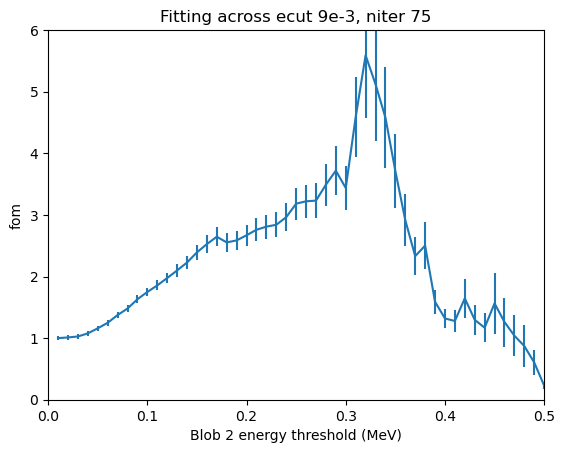

In [7]:
plt.errorbar(cut_list, fom_out[0], yerr = fom_out[1])
plt.title("Fitting across ecut 9e-3, niter 75")
plt.xlabel("Blob 2 energy threshold (MeV)")
plt.xlim([0,0.5])
plt.ylim([0,6])
plt.ylabel("fom")

In [8]:
np.save('fittingfom.npy', fom_out)
np.save('blob2vals.npy', cut_list)

No handles with labels found to put in legend.


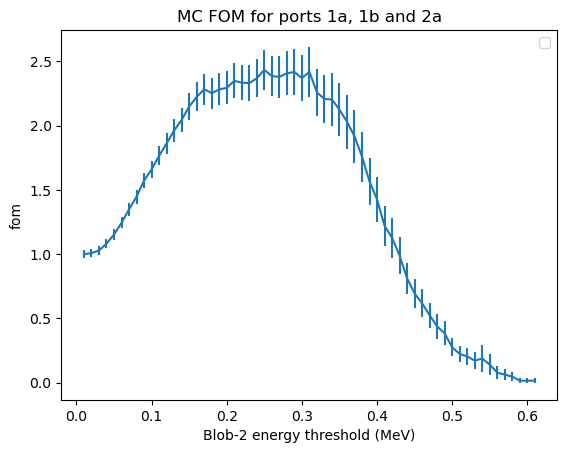

In [9]:
cut_tracks = cut_tracks[0]
# collect positron events and non-positron events
ecut_positron_df = cut_tracks[cut_tracks['event'].isin(pos_events['event_id'].to_numpy())]
ecut_no_positron_df = cut_tracks[~cut_tracks['event'].isin(pos_events['event_id'].to_numpy())]

fom = func.true_fom_calc(ecut_positron_df, ecut_no_positron_df, cut_list)

ns = fom[2]
nb = fom[3]
fom_erro = np.nan_to_num(fom[1])
fom = np.nan_to_num(fom[0])

plt.errorbar(cut_list, fom, yerr = fom_erro)
plt.title("MC FOM for ports 1a, 1b and 2a")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.legend()

plt.ylabel("fom")
plt.show()

In [10]:
# plot together
print(cut_list)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61]


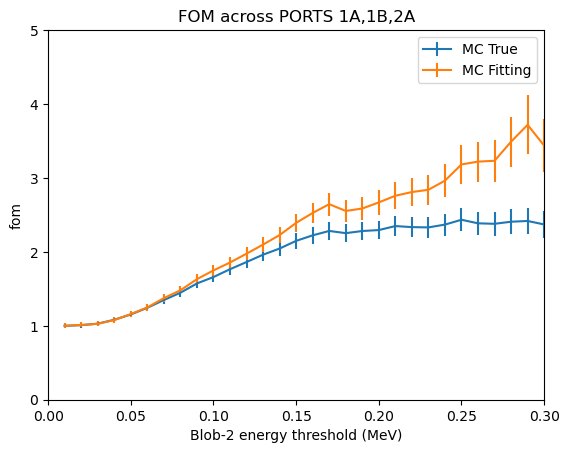

In [14]:
plt.errorbar(cut_list, fom, yerr = fom_erro, label = "MC True")
plt.errorbar(cut_list, fom_out[0], yerr = fom_out[1], label = "MC Fitting")
plt.xlim([0, 0.3])
plt.ylim([0,5])
plt.legend()
plt.title("FOM across PORTS 1A,1B,2A")
plt.xlabel("Blob-2 energy threshold (MeV)")

plt.ylabel("fom")
plt.show()

In [23]:
print(fom_out[1])

[0.03323828165789762, 0.03370737546714177, 0.03447107223592547, 0.03658184913343484, 0.040093415695306334, 0.04418129503790743, 0.050132184200644754, 0.05571982124544418, 0.06437354321804575, 0.07193169722747421, 0.07933435299856346, 0.08837350370041144, 0.09869114291435385, 0.11011112388172227, 0.12538769556583654, 0.14050053712193372, 0.15464461717759515, 0.14975228453570744, 0.15620203291298382, 0.1672565387148321, 0.18268835132388933, 0.192663054320818, 0.20120138704539273, 0.22195743056523537, 0.2585107711212455, 0.2711504908558566, 0.28295356438671787, 0.33867378617266247, 0.3987283740762804, 0.35903766452880637, 0.6505996017788443, 1.0123587273896386, 0.9306129003980446, 0.8179441894575631, 0.5982561449492034, 0.4204351736538019, 0.30616841582656595, 0.3834346644371352, 0.1932630840666371, 0.15685123608759757, 0.1719639269218056, 0.31288238778179556, 0.23994008789590937, 0.23487092687633734, 0.4969202417607702, 0.3979813900730647, 0.33441479684362135, 0.3357287945775089, 0.20643

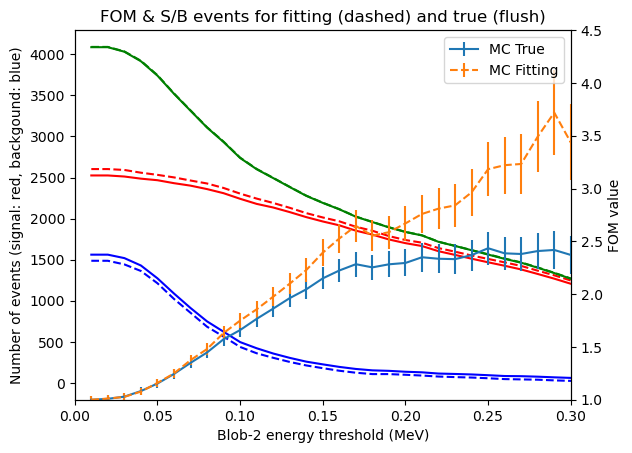

In [84]:
# plot number of events across the cut list for MC true and MC fitting
# this isn't correct (removing the last element), but i think it'll be okay

fig, ax1 = plt.subplots()

ax1.plot(cut_list, ns[:-1], label = "Signal events - MC TRUE", color = 'red')
ax1.plot(cut_list, nb[:-1], label = "Background events - MC TRUE", color = 'blue')
ax1.plot(cut_list, fom_out[2][:-1], label = "Signal events - MC FIT", linestyle = 'dashed', color = 'red')
ax1.plot(cut_list, fom_out[3][:-1], label = "Background events - MC FIT", linestyle = 'dashed', color = 'blue')

nt = [sum(x) for x in zip(ns[:-1], nb[:-1])]
nt_fit = [sum(x) for x in zip(fom_out[2][:-1], fom_out[3][:-1])]

ax1.plot(cut_list, nt, label = "Total events - MC TRUE", color = 'green')
ax1.plot(cut_list, nt_fit, label = "Total events - MC FIT", color = 'green', linestyle = 'dashed')

ax2 = ax1.twinx()

ax2.errorbar(cut_list, fom, yerr = fom_erro, label = "MC True")
ax2.errorbar(cut_list, fom_out[0], yerr = fom_out[1], label = "MC Fitting", linestyle = 'dashed')
ax2.set_ylim([1, 4.5])

plt.xlim([0, 0.3])
ax1.set_ylabel("Number of events (signal: red, backgound: blue)")
ax2.set_ylabel("FOM value")
ax1.set_xlabel("Blob-2 energy threshold (MeV)")
ax2.legend()
plt.title("FOM & S/B events for fitting (dashed) and true (flush)")
plt.show()

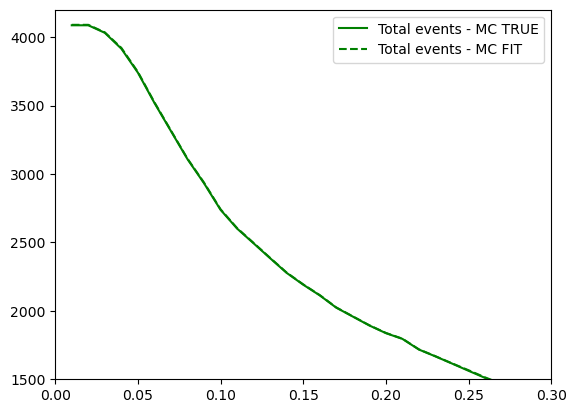

In [89]:
plt.plot(cut_list, nt, label = "Total events - MC TRUE", color = 'green')
plt.plot(cut_list, nt_fit, label = "Total events - MC FIT", color = 'green', linestyle = 'dashed')
plt.legend()
plt.ylim([1500, 4200])
plt.xlim([0,0.3])
plt.show()


Obtaining C1 and C2
=========================== SIGNAL FIT ============================


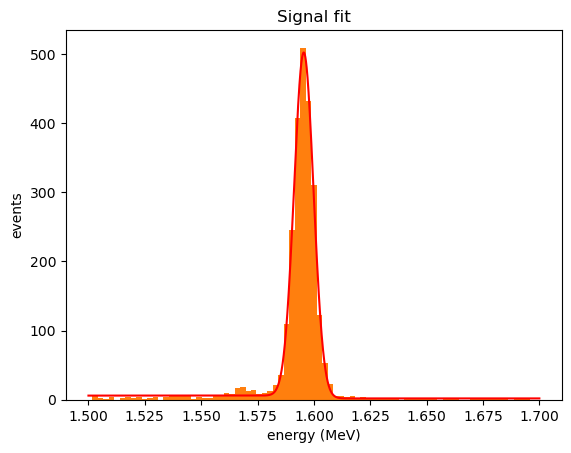

        Fitting output      
B1: 5.3794 ± 1.9020
A: 0.0176 ± 136.1038
mu: 1.5955 ± 0.4677
sigma: 0.0043 ± 0.0079
C1: 0.3779 ± 0.1569
C2: 0.3520 ± 0.2115
C1: 0.37792968058787235, C2: 0.3519561034730971
mu: 1.5954169538727059, sigma: 0.004595281255864209
=========================== GAUSSIAN FIT ============================


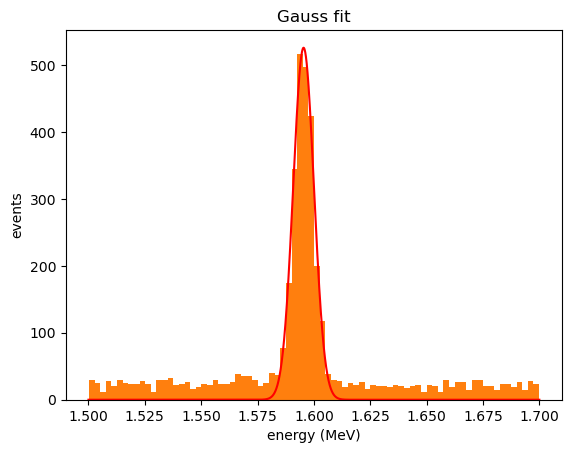

        Fitting output      
A: 525.6724 ± 16.2472
mu: 1.5954 ± 0.0002
sigma: 0.0046 ± 0.0002
=========================== FULL FIT ============================


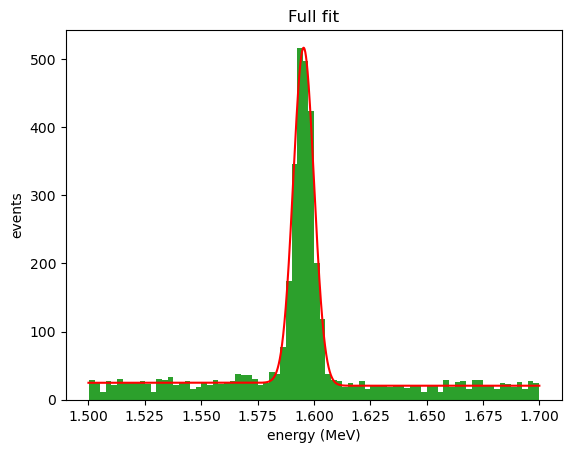

        Fitting output      
ns: 5.6850 ± 0.0620
a: 0.0087 ± 0.0184
nb: 18.5504 ± 28.2010
tau: 778825.2358 ± 311921962959.5612
ns0      = 2602.6364349512705
nb0      = 1486.627221175132
total    = 4089
Event no = 4086
=========================== ====================== ===========================
=========================== BLOB 2 CUT STARTS HERE ===========================
=========================== ====================== ===========================
Applying cut 0.01 MeV
=========================== GAUSSIAN FIT ============================


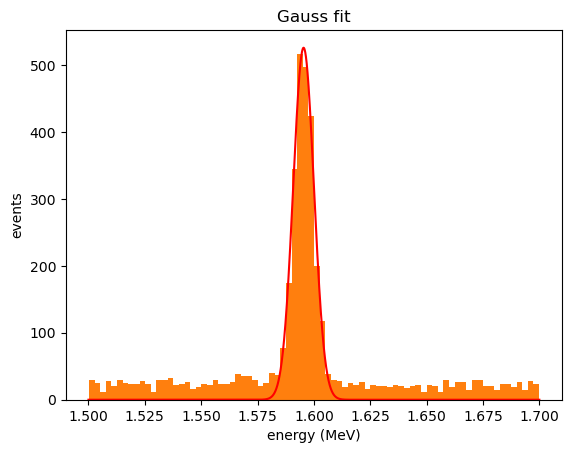

        Fitting output      
A: 525.6724 ± 16.2472
mu: 1.5954 ± 0.0002
sigma: 0.0046 ± 0.0002
=========================== FULL FIT ============================


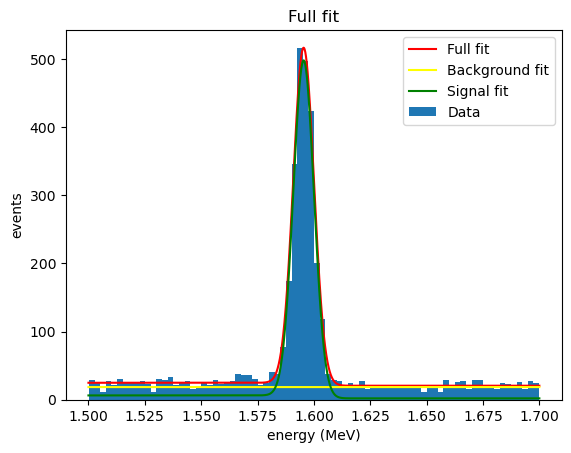

        Fitting output      
ns: 5.6850 ± 0.0617
a: 0.0087 ± 0.0184
nb: 18.5504 ± 28.6490
tau: 661740.4754 ± 422153724083.0421
ns - 2602.6364316781974
nb - 1486.627189593943
total = 4089
Event no = 4086
fom - 1.00 ± 0.03
e - 1.00 ± 0.03
b - 1.00 ± 0.04
Applying cut 0.02 MeV
=========================== GAUSSIAN FIT ============================


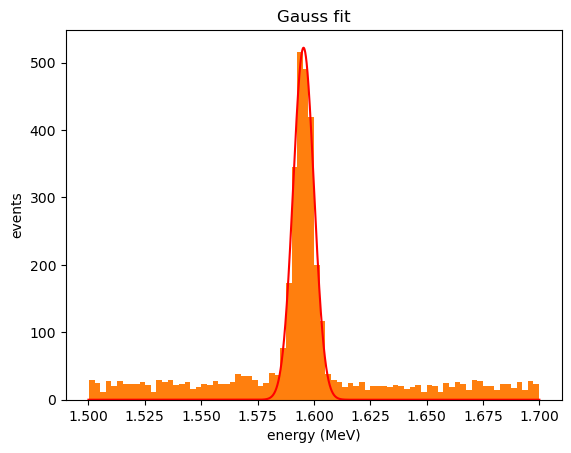

        Fitting output      
A: 521.9842 ± 15.8462
mu: 1.5954 ± 0.0002
sigma: 0.0046 ± 0.0002
=========================== FULL FIT ============================


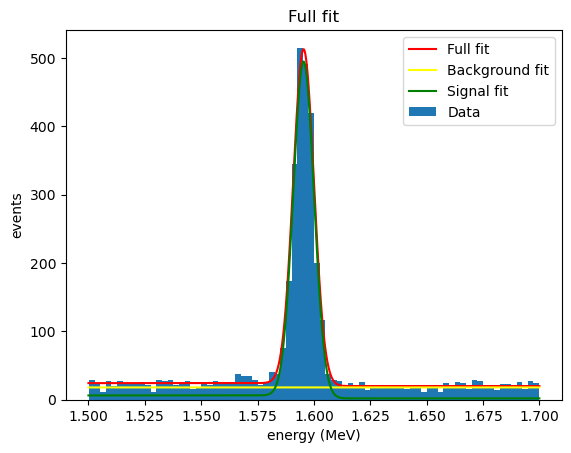

        Fitting output      
ns: 5.6615 ± 0.0606
a: 0.0087 ± 0.0182
nb: 17.9978 ± 26.6445
tau: 782682.3476 ± 566072617757.4343
ns - 2591.8390711873312
nb - 1442.3447522918266
total = 4034
Event no = 4031
fom - 1.01 ± 0.03
e - 1.00 ± 0.03
b - 0.97 ± 0.04
Applying cut 0.03 MeV
=========================== GAUSSIAN FIT ============================


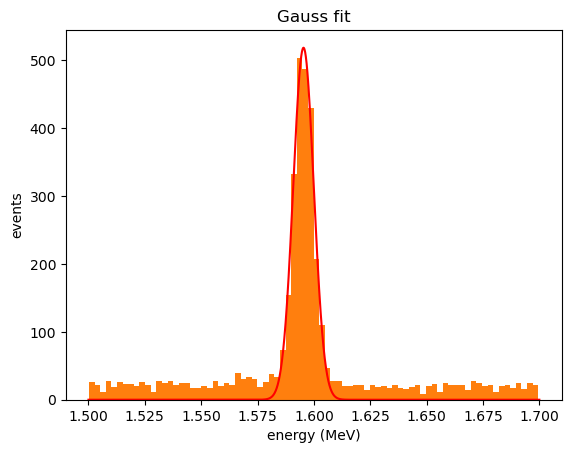

        Fitting output      
A: 518.5223 ± 15.2440
mu: 1.5954 ± 0.0002
sigma: 0.0046 ± 0.0002
=========================== FULL FIT ============================


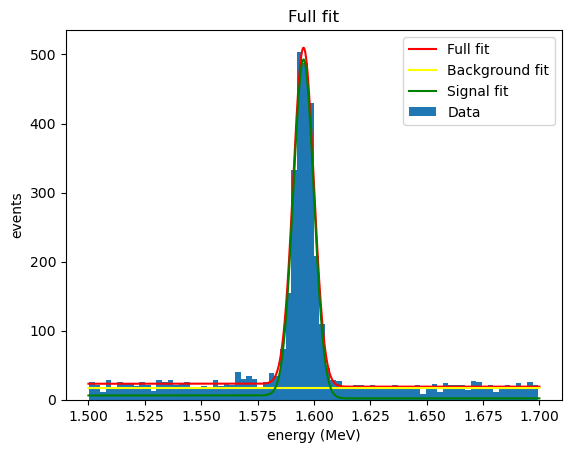

        Fitting output      
ns: 5.5785 ± 0.0598
a: 0.0086 ± 0.0183
nb: 16.9678 ± 27.8127
tau: 333567.7071 ± 113921839158.6294
ns - 2558.5268239794514
nb - 1362.3056143759147
total = 3921
Event no = 3915
fom - 1.03 ± 0.03
e - 0.98 ± 0.03
b - 0.92 ± 0.03
Applying cut 0.04 MeV
=========================== GAUSSIAN FIT ============================


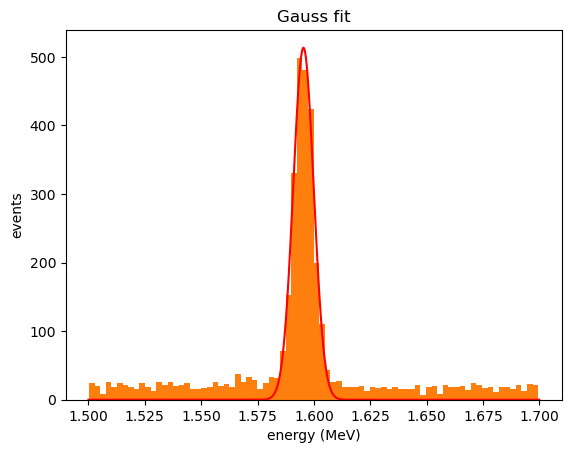

        Fitting output      
A: 513.4173 ± 14.1021
mu: 1.5954 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


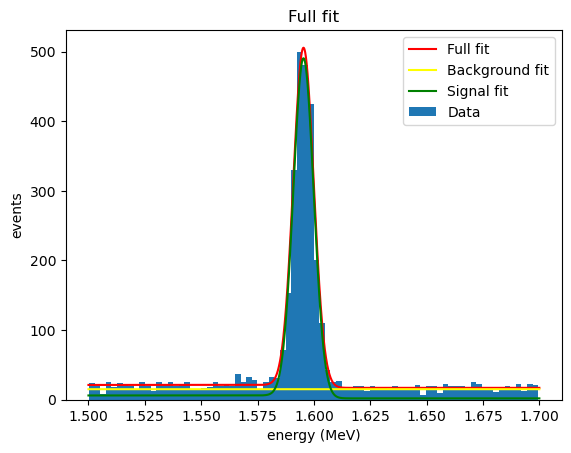

        Fitting output      
ns: 5.5214 ± 0.0587
a: 0.0086 ± 0.0181
nb: 15.1078 ± 1.0517
tau: 1489176.3556 ± 0.0000
ns - 2532.306429189296
nb - 1212.979486703895
total = 3745
Event no = 3740
fom - 1.08 ± 0.04
e - 0.97 ± 0.03
b - 0.82 ± 0.03
Applying cut 0.05 MeV
=========================== GAUSSIAN FIT ============================


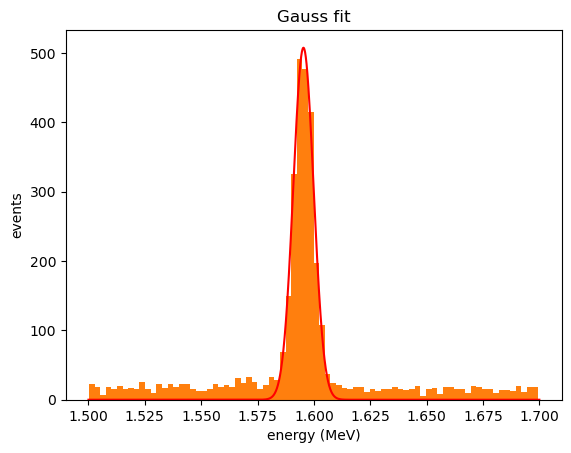

        Fitting output      
A: 507.8225 ± 12.5276
mu: 1.5954 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


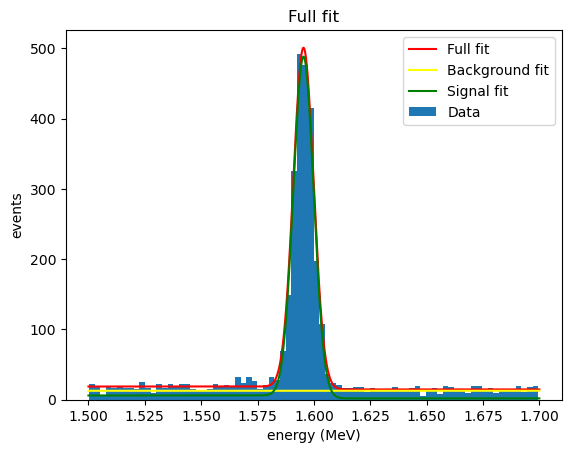

        Fitting output      
ns: 5.4538 ± 0.0544
a: 0.0085 ± 0.0170
nb: 12.7325 ± 24.4227
tau: 627726.4749 ± 471796463642.3248
ns - 2501.320789332377
nb - 1022.2696954466992
total = 3524
Event no = 3519
fom - 1.16 ± 0.04
e - 0.96 ± 0.03
b - 0.69 ± 0.03
Applying cut 0.060000000000000005 MeV
=========================== GAUSSIAN FIT ============================


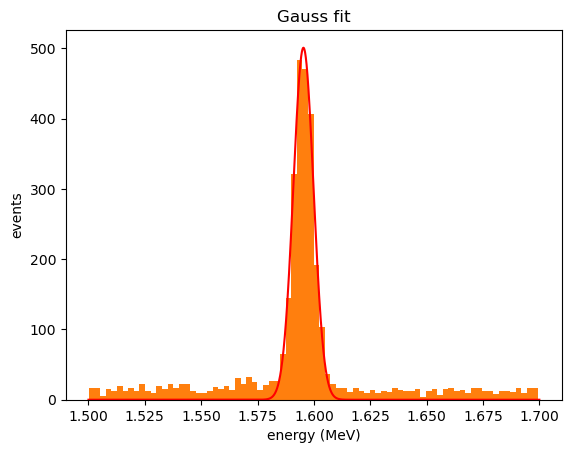

        Fitting output      
A: 500.8775 ± 11.1964
mu: 1.5954 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


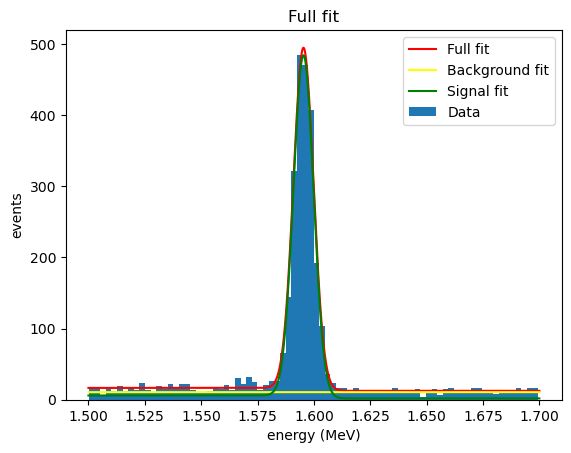

        Fitting output      
ns: 5.3710 ± 0.0522
a: 0.0085 ± 0.0165
nb: 10.6322 ± 24.4188
tau: 270534.8110 ± 104918336884.0906
ns - 2463.332418424259
nb - 853.6391140439798
total = 3317
Event no = 3313
fom - 1.25 ± 0.04
e - 0.95 ± 0.03
b - 0.57 ± 0.02
Applying cut 0.06999999999999999 MeV
=========================== GAUSSIAN FIT ============================


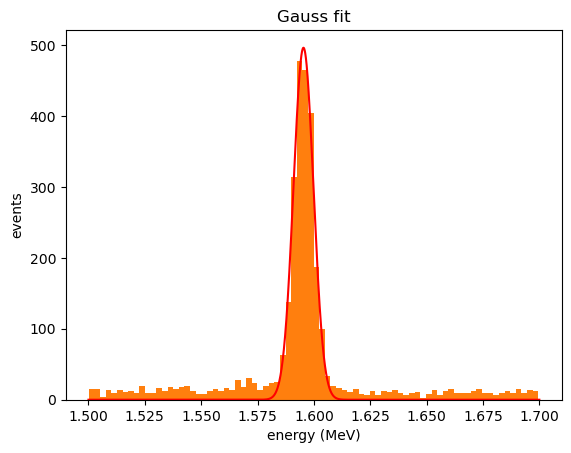

        Fitting output      
A: 496.2171 ± 9.9394
mu: 1.5954 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


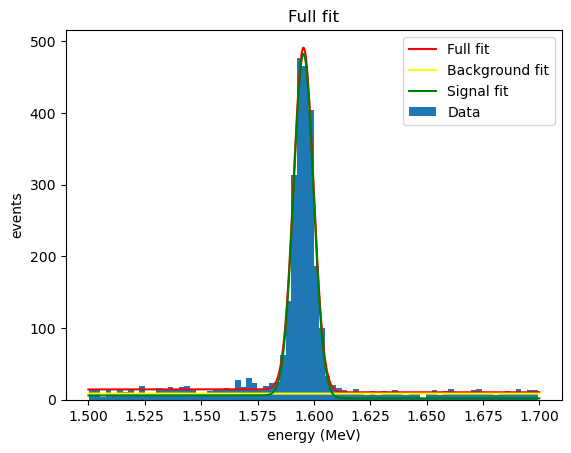

        Fitting output      
ns: 5.2922 ± 0.0502
a: 0.0084 ± 0.0161
nb: 8.5211 ± 23.1534
tau: 312932.2833 ± 166199790606.0830
ns - 2427.2089352829344
nb - 684.1408489252849
total = 3111
Event no = 3108
fom - 1.37 ± 0.05
e - 0.93 ± 0.03
b - 0.46 ± 0.02
Applying cut 0.08 MeV
=========================== GAUSSIAN FIT ============================


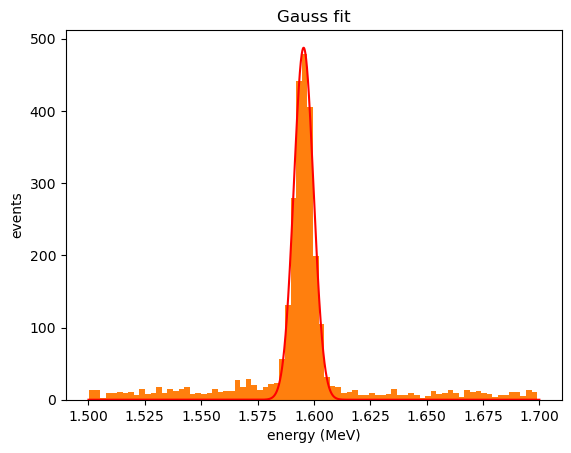

        Fitting output      
A: 487.3885 ± 8.5250
mu: 1.5954 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


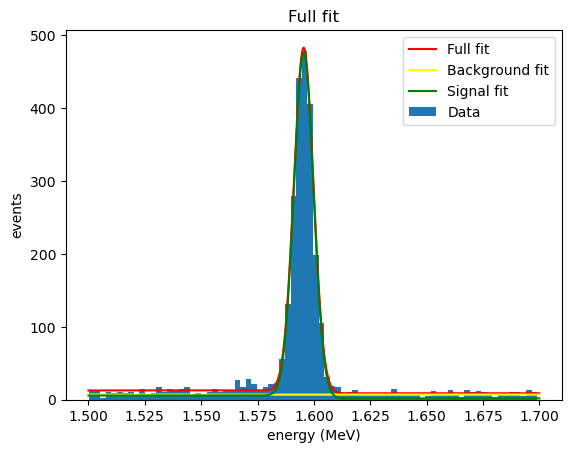

        Fitting output      
ns: 5.1607 ± 0.0397
a: 0.0083 ± 0.0131
nb: 7.0074 ± 18.9955
tau: 184983.6083 ± 57898192833.6953
ns - 2372.636971296714
nb - 563.9481759339158
total = 2937
Event no = 2932
fom - 1.48 ± 0.06
e - 0.91 ± 0.03
b - 0.38 ± 0.02
Applying cut 0.09 MeV
=========================== GAUSSIAN FIT ============================


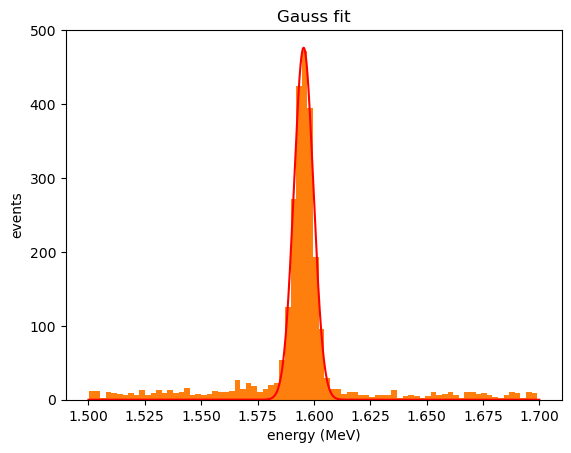

        Fitting output      
A: 476.2705 ± 7.3785
mu: 1.5954 ± 0.0001
sigma: 0.0043 ± 0.0001
=========================== FULL FIT ============================


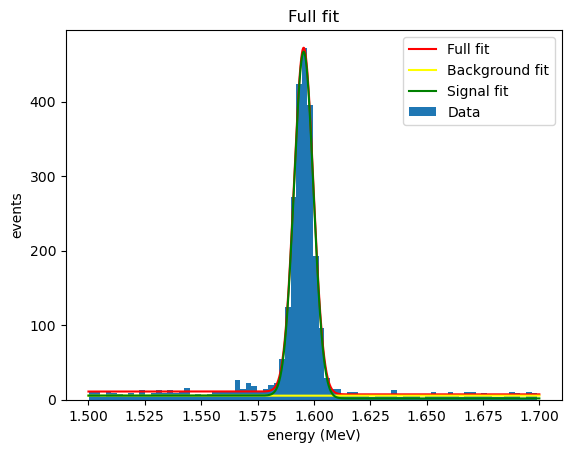

        Fitting output      
ns: 5.0113 ± 0.0351
a: 0.0082 ± 0.0119
nb: 5.4404 ± 16.9919
tau: 143326.2283 ± 40068595759.3681
ns - 2303.959001051114
nb - 437.8383909444741
total = 2742
Event no = 2738
fom - 1.63 ± 0.06
e - 0.89 ± 0.03
b - 0.29 ± 0.02
Applying cut 0.09999999999999999 MeV
=========================== GAUSSIAN FIT ============================


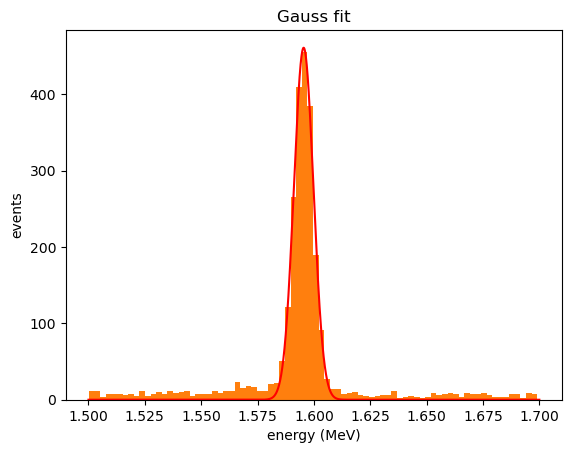

        Fitting output      
A: 461.0978 ± 6.5797
mu: 1.5954 ± 0.0001
sigma: 0.0043 ± 0.0001
=========================== FULL FIT ============================


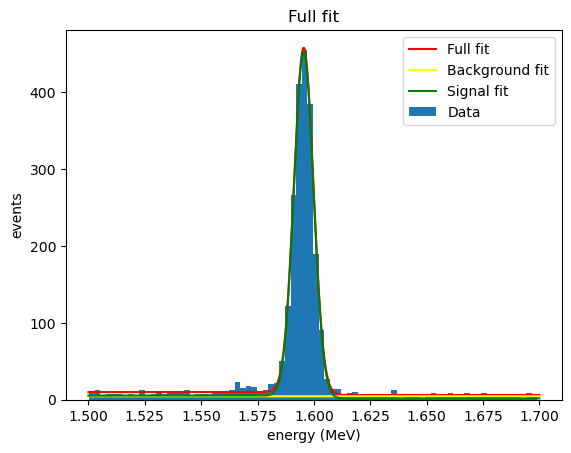

        Fitting output      
ns: 4.8795 ± 0.0320
a: 0.0082 ± 0.0114
nb: 4.4848 ± 15.3797
tau: 182938.6191 ± 71655867506.3930
ns - 2243.3730541093246
nb - 360.93457651082406
total = 2604
Event no = 2601
fom - 1.75 ± 0.07
e - 0.86 ± 0.02
b - 0.24 ± 0.01
Applying cut 0.11 MeV
=========================== GAUSSIAN FIT ============================


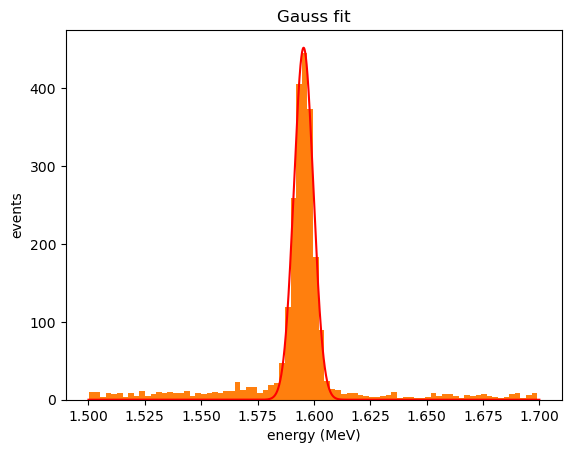

        Fitting output      
A: 452.2025 ± 6.0847
mu: 1.5954 ± 0.0001
sigma: 0.0043 ± 0.0001
=========================== FULL FIT ============================


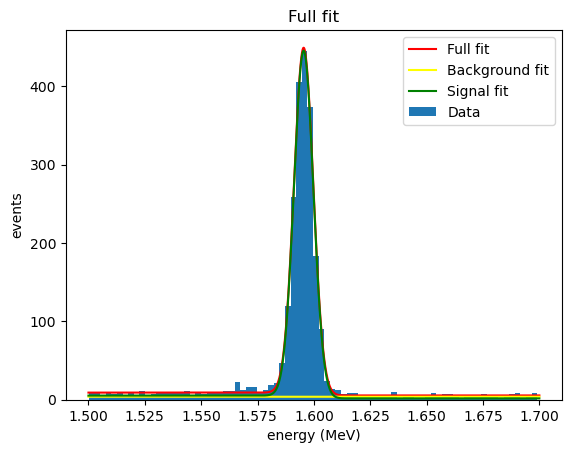

        Fitting output      
ns: 4.7641 ± 0.0301
a: 0.0081 ± 0.0108
nb: 3.7976 ± 14.6667
tau: 69475.5460 ± 11641884048.0822
ns - 2190.3220637319455
nb - 305.62704600991736
total = 2496
Event no = 2493
fom - 1.86 ± 0.08
e - 0.84 ± 0.02
b - 0.21 ± 0.01
Applying cut 0.12 MeV
=========================== GAUSSIAN FIT ============================


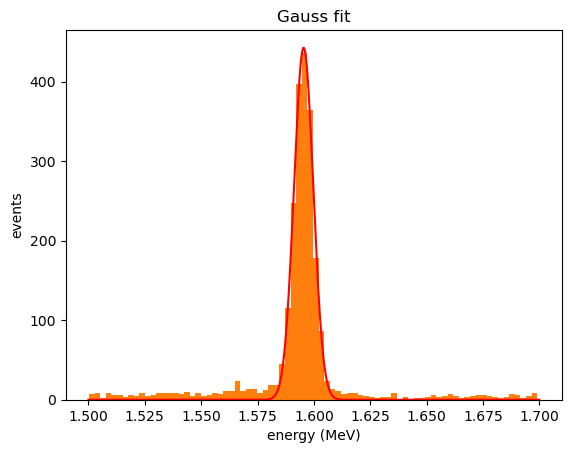

        Fitting output      
A: 442.7098 ± 5.6109
mu: 1.5954 ± 0.0001
sigma: 0.0043 ± 0.0001
=========================== FULL FIT ============================


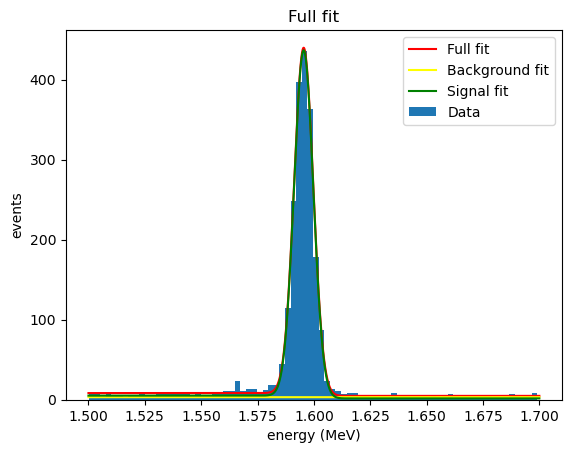

        Fitting output      
ns: 4.6356 ± 0.0288
a: 0.0081 ± 0.0106
nb: 3.1731 ± 14.1337
tau: 96347.9092 ± 25819265302.0534
ns - 2131.2557228837345
nb - 255.36446914405363
total = 2387
Event no = 2384
fom - 1.98 ± 0.09
e - 0.82 ± 0.02
b - 0.17 ± 0.01
Applying cut 0.13 MeV
=========================== GAUSSIAN FIT ============================


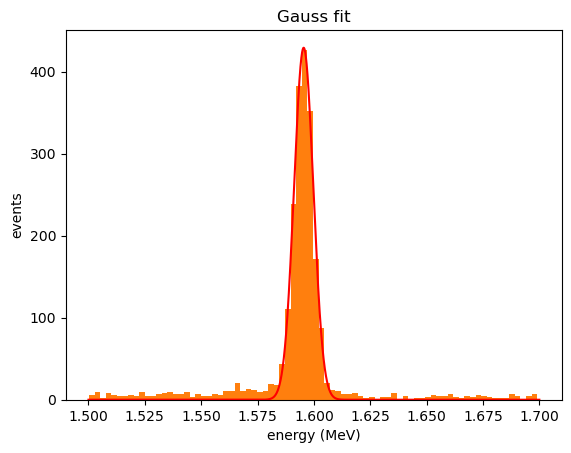

        Fitting output      
A: 429.2740 ± 5.2685
mu: 1.5955 ± 0.0001
sigma: 0.0043 ± 0.0001
=========================== FULL FIT ============================


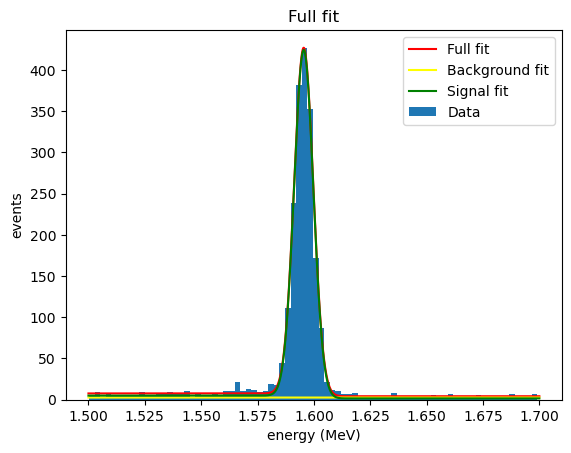

        Fitting output      
ns: 4.4948 ± 0.0285
a: 0.0081 ± 0.0108
nb: 2.6441 ± 13.9289
tau: 33447.8904 ± 3680509510.2256
ns - 2066.549065191354
nb - 212.78315372960165
total = 2279
Event no = 2277
fom - 2.10 ± 0.10
e - 0.79 ± 0.02
b - 0.14 ± 0.01
Applying cut 0.14 MeV
=========================== GAUSSIAN FIT ============================


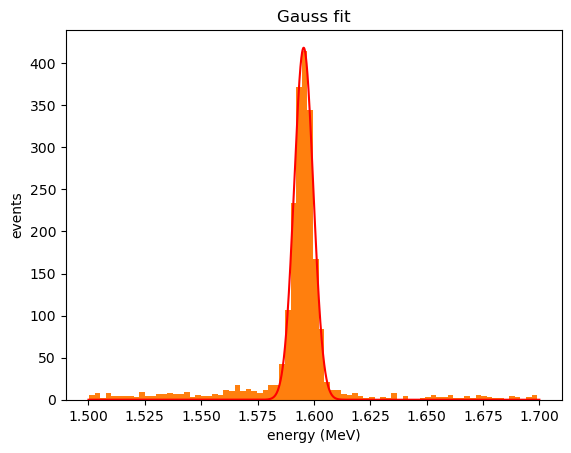

        Fitting output      
A: 418.3462 ± 4.8864
mu: 1.5955 ± 0.0001
sigma: 0.0043 ± 0.0001
=========================== FULL FIT ============================


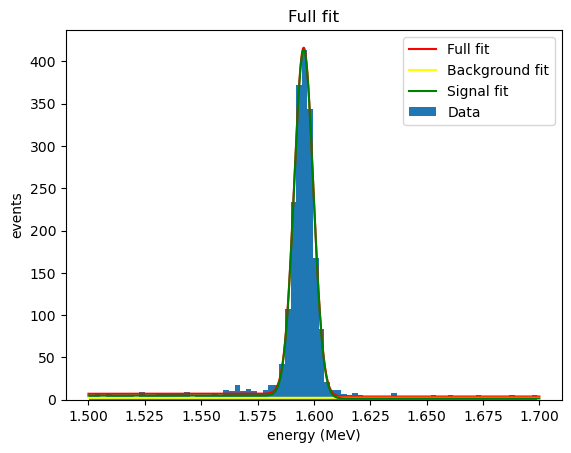

        Fitting output      
ns: 4.3801 ± 0.0268
a: 0.0080 ± 0.0104
nb: 1.7607 ± 10.3848
tau: -6.7944 ± 169.8996
ns - 2013.792633751026
nb - 179.33544445946418
total = 2193
Event no = 2191
fom - 2.23 ± 0.11
e - 0.77 ± 0.02
b - 0.12 ± 0.01
Applying cut 0.15000000000000002 MeV
=========================== GAUSSIAN FIT ============================


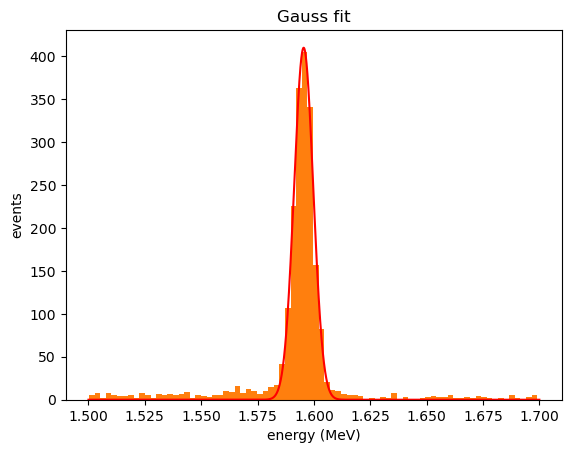

        Fitting output      
A: 409.7385 ± 4.8795
mu: 1.5955 ± 0.0001
sigma: 0.0042 ± 0.0001
=========================== FULL FIT ============================


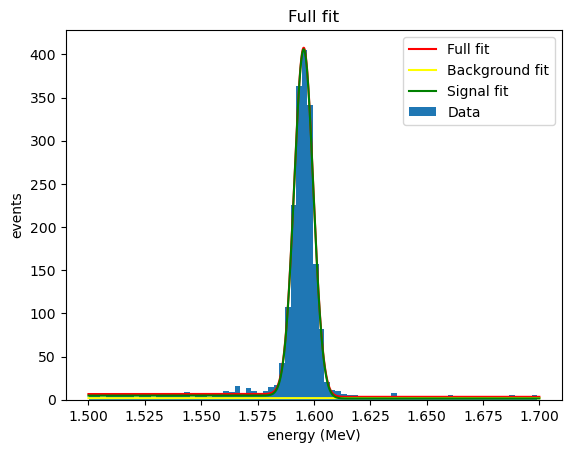

        Fitting output      
ns: 4.2775 ± 0.0298
a: 0.0080 ± 0.0119
nb: 1.8426 ± 14.1133
tau: 75028.6716 ± 26926228109.6250
ns - 1966.6047368746606
nb - 148.29201182700672
total = 2115
Event no = 2113
fom - 2.39 ± 0.13
e - 0.76 ± 0.02
b - 0.10 ± 0.01
Applying cut 0.16 MeV
=========================== GAUSSIAN FIT ============================


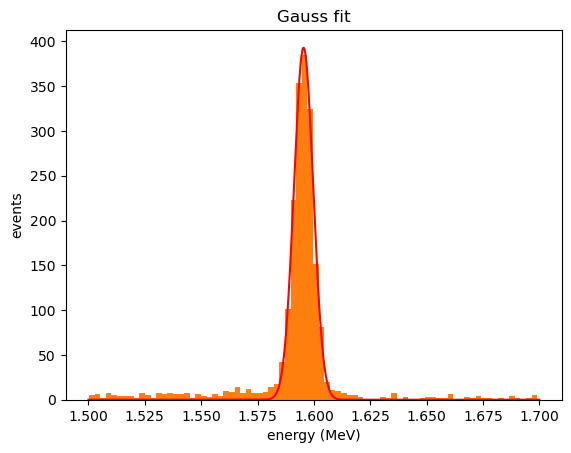

        Fitting output      
A: 392.9623 ± 4.5413
mu: 1.5954 ± 0.0001
sigma: 0.0043 ± 0.0001
=========================== FULL FIT ============================


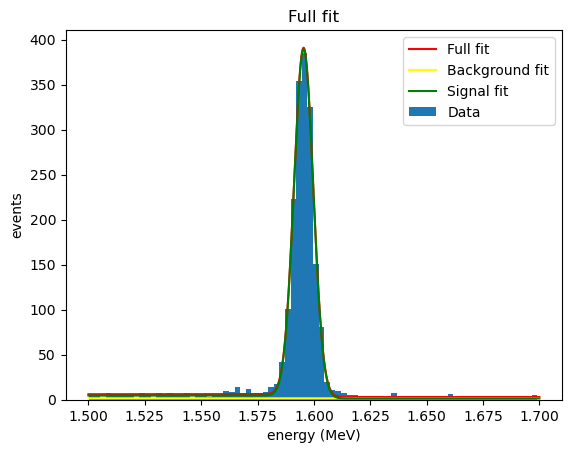

        Fitting output      
ns: 4.1339 ± 0.0290
a: 0.0081 ± 0.0117
nb: 1.5428 ± 13.7476
tau: -61608.1719 ± 21137764667.5406
ns - 1900.550671819592
nb - 124.16828560079391
total = 2025
Event no = 2023
fom - 2.53 ± 0.14
e - 0.73 ± 0.02
b - 0.08 ± 0.01
Applying cut 0.17 MeV
=========================== GAUSSIAN FIT ============================


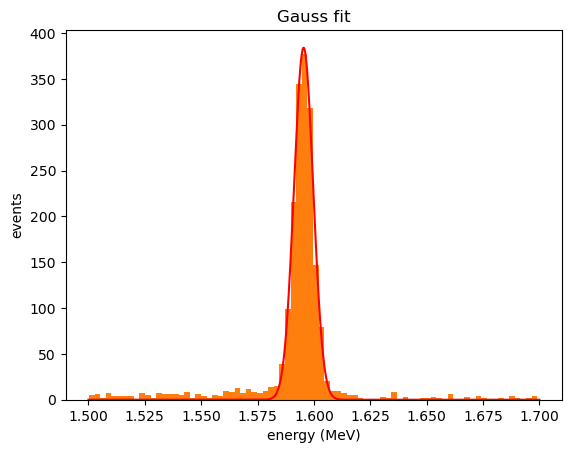

        Fitting output      
A: 383.9386 ± 4.3676
mu: 1.5954 ± 0.0001
sigma: 0.0043 ± 0.0001
=========================== FULL FIT ============================


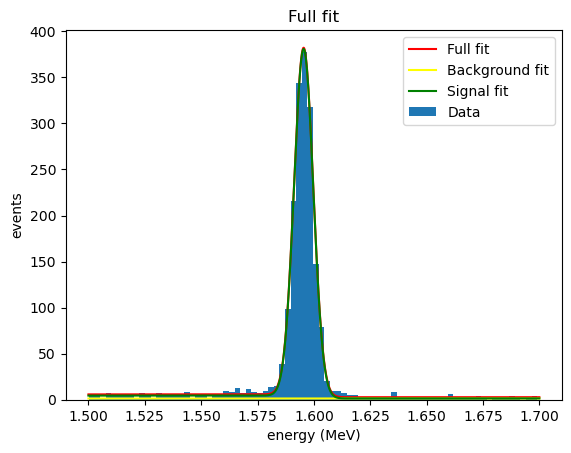

        Fitting output      
ns: 4.0284 ± 0.0279
a: 0.0081 ± 0.0118
nb: 1.3366 ± 13.6475
tau: 10811.5935 ± 745236394.0469
ns - 1852.0417083141479
nb - 107.55306102137341
total = 1960
Event no = 1958
fom - 2.65 ± 0.15
e - 0.71 ± 0.02
b - 0.07 ± 0.01
Applying cut 0.18000000000000002 MeV
=========================== GAUSSIAN FIT ============================


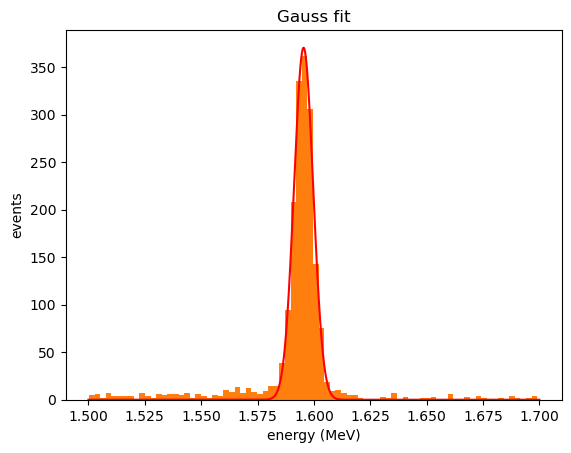

        Fitting output      
A: 370.5577 ± 4.2374
mu: 1.5954 ± 0.0001
sigma: 0.0043 ± 0.0001
=========================== FULL FIT ============================


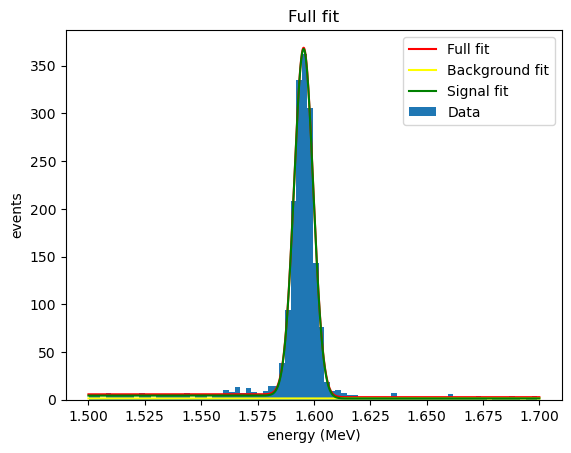

        Fitting output      
ns: 3.8871 ± 0.0269
a: 0.0081 ± 0.0118
nb: 1.8810 ± 18.5612
tau: 4.6688 ± 134.4386
ns - 1787.088384605405
nb - 107.46454722407624
total = 1895
Event no = 1893
fom - 2.55 ± 0.15
e - 0.69 ± 0.02
b - 0.07 ± 0.01
Applying cut 0.19 MeV
=========================== GAUSSIAN FIT ============================


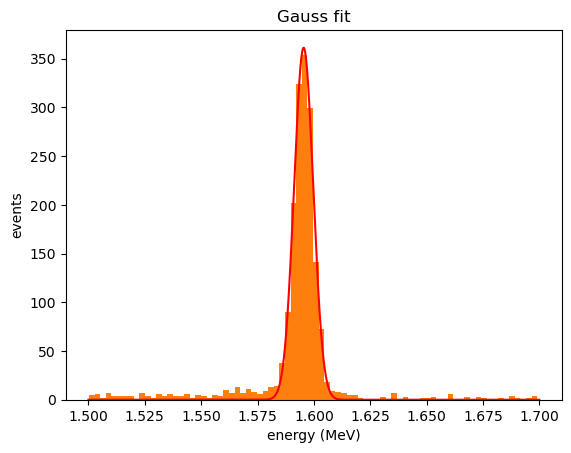

        Fitting output      
A: 361.2752 ± 4.0198
mu: 1.5954 ± 0.0001
sigma: 0.0042 ± 0.0001
=========================== FULL FIT ============================


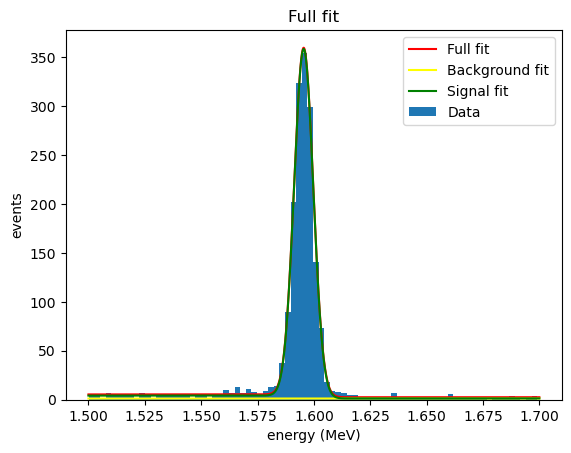

        Fitting output      
ns: 3.7830 ± 0.0253
a: 0.0080 ± 0.0114
nb: 1.2329 ± 12.1414
tau: -49139.9468 ± 14841277121.4133
ns - 1739.2580857895382
nb - 99.22900430675445
total = 1838
Event no = 1837
fom - 2.59 ± 0.16
e - 0.67 ± 0.02
b - 0.07 ± 0.01
Applying cut 0.2 MeV
=========================== GAUSSIAN FIT ============================


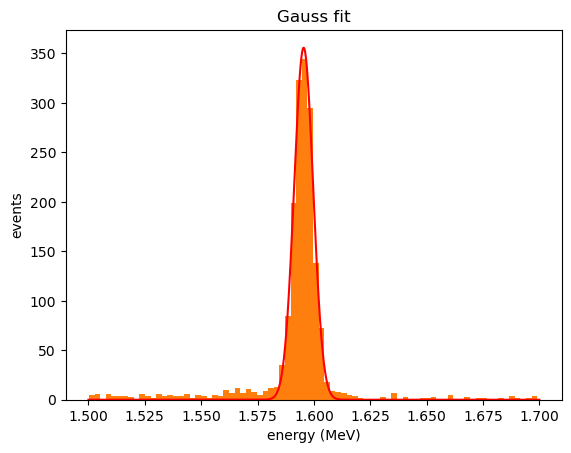

        Fitting output      
A: 355.8036 ± 4.0095
mu: 1.5954 ± 0.0001
sigma: 0.0042 ± 0.0001
=========================== FULL FIT ============================


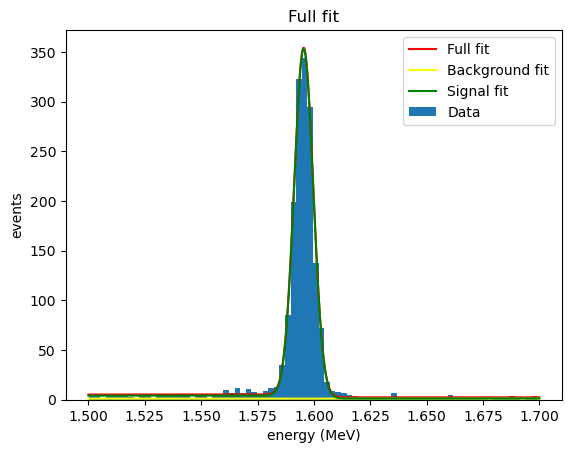

        Fitting output      
ns: 3.7122 ± 0.0262
a: 0.0080 ± 0.0125
nb: 1.1146 ± 11.8498
tau: 87437.8174 ± 50754864630.5159
ns - 1706.7113301884644
nb - 89.70223084731454
total = 1796
Event no = 1795
fom - 2.67 ± 0.17
e - 0.66 ± 0.02
b - 0.06 ± 0.01
Applying cut 0.21000000000000002 MeV
=========================== GAUSSIAN FIT ============================


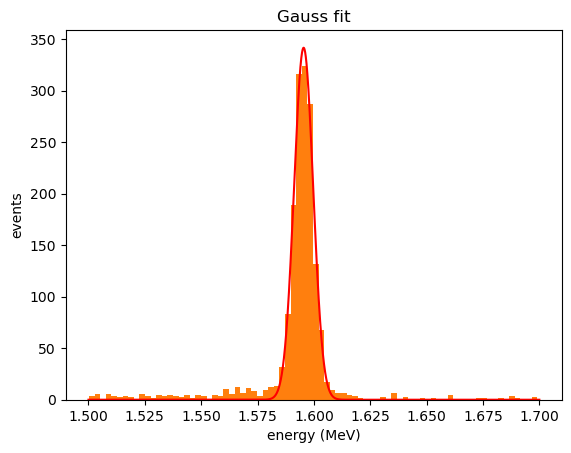

        Fitting output      
A: 341.7279 ± 4.1596
mu: 1.5954 ± 0.0001
sigma: 0.0042 ± 0.0001
=========================== FULL FIT ============================


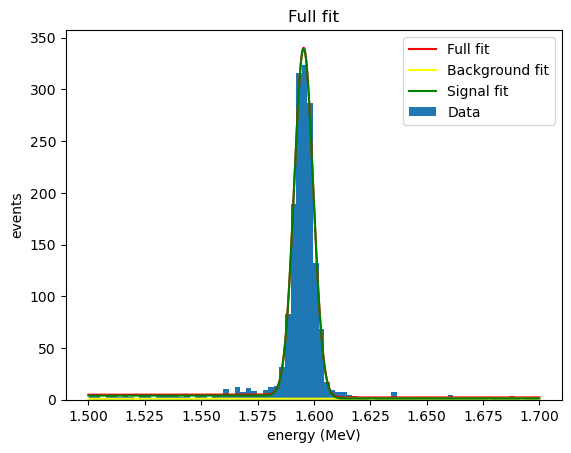

        Fitting output      
ns: 3.5687 ± 0.0294
a: 0.0080 ± 0.0140
nb: 0.4803 ± 7.2167
tau: -2.2967 ± 49.3970
ns - 1640.73803764373
nb - 77.59932191820012
total = 1718
Event no = 1717
fom - 2.76 ± 0.18
e - 0.63 ± 0.02
b - 0.05 ± 0.01
Applying cut 0.22 MeV
=========================== GAUSSIAN FIT ============================


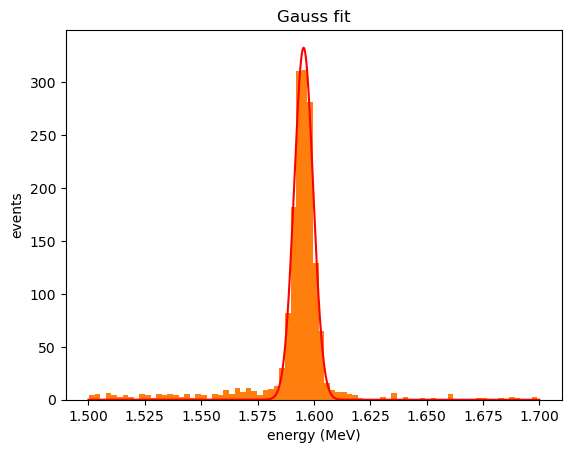

        Fitting output      
A: 332.7018 ± 4.1900
mu: 1.5954 ± 0.0001
sigma: 0.0042 ± 0.0001
=========================== FULL FIT ============================


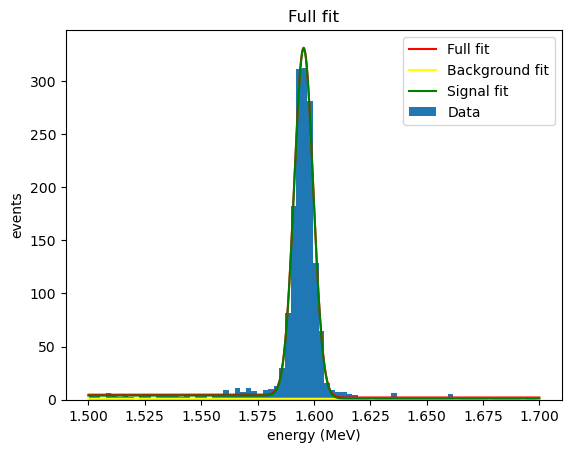

        Fitting output      
ns: 3.4743 ± 0.0305
a: 0.0080 ± 0.0150
nb: 0.8815 ± 14.6483
tau: 31383.4902 ± 10217902342.4476
ns - 1597.3056261663735
nb - 70.93967730378792
total = 1668
Event no = 1667
fom - 2.81 ± 0.19
e - 0.61 ± 0.02
b - 0.05 ± 0.01
Applying cut 0.23 MeV
=========================== GAUSSIAN FIT ============================


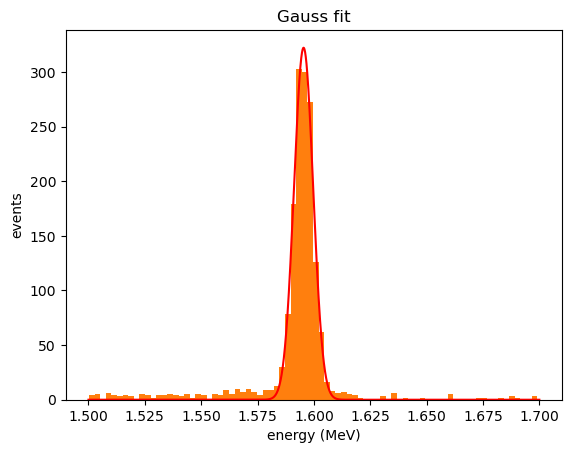

        Fitting output      
A: 322.0927 ± 4.0879
mu: 1.5954 ± 0.0001
sigma: 0.0042 ± 0.0001
=========================== FULL FIT ============================


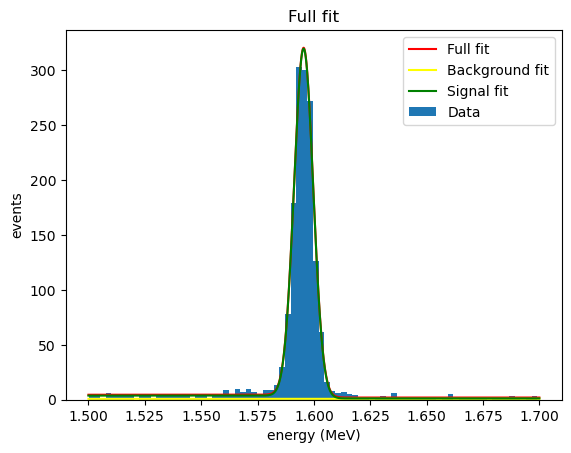

        Fitting output      
ns: 3.3731 ± 0.0304
a: 0.0080 ± 0.0152
nb: 0.8130 ± 14.6512
tau: 87802.6842 ± 86789500759.0014
ns - 1550.7612820445645
nb - 65.42714241207794
total = 1616
Event no = 1615
fom - 2.84 ± 0.20
e - 0.60 ± 0.02
b - 0.04 ± 0.01
Applying cut 0.24000000000000002 MeV
=========================== GAUSSIAN FIT ============================


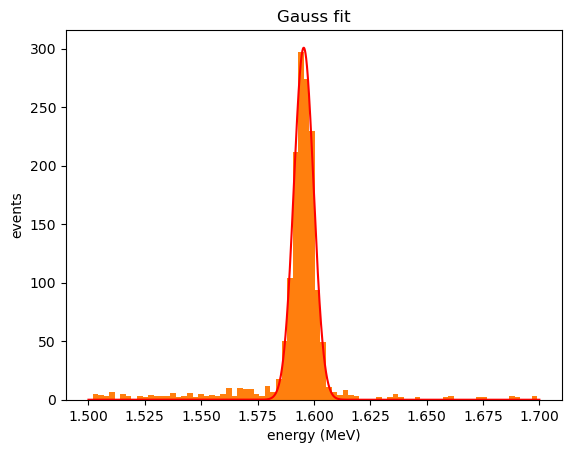

        Fitting output      
A: 300.7999 ± 3.7715
mu: 1.5955 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


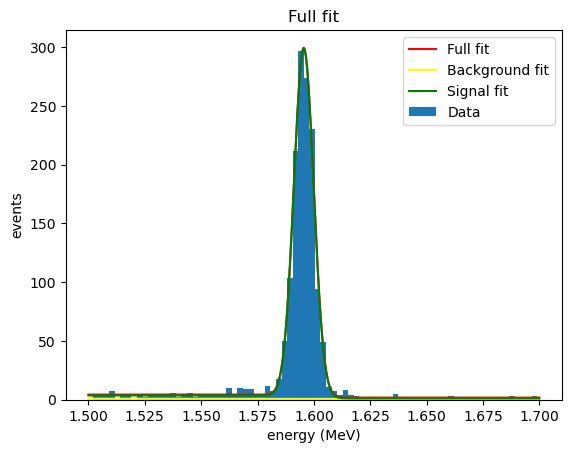

        Fitting output      
ns: 3.2558 ± 0.0285
a: 0.0083 ± 0.0149
nb: 2.7209 ± 53.9662
tau: 1.1791 ± 17.2737
ns - 1509.0766985506832
nb - 56.90073014128886
total = 1566
Event no = 1562
fom - 2.96 ± 0.22
e - 0.58 ± 0.02
b - 0.04 ± 0.01
Applying cut 0.25 MeV
=========================== GAUSSIAN FIT ============================


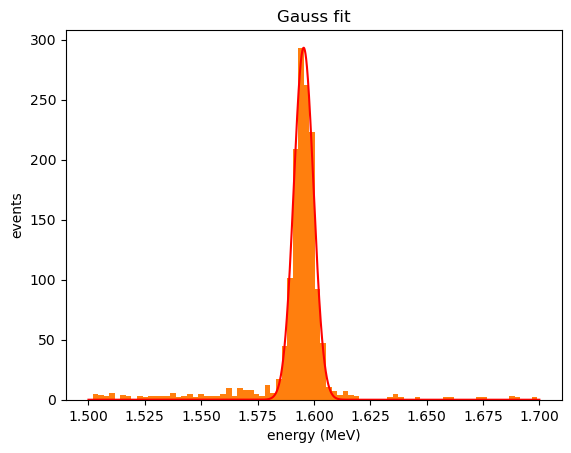

        Fitting output      
A: 293.2787 ± 3.7482
mu: 1.5955 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


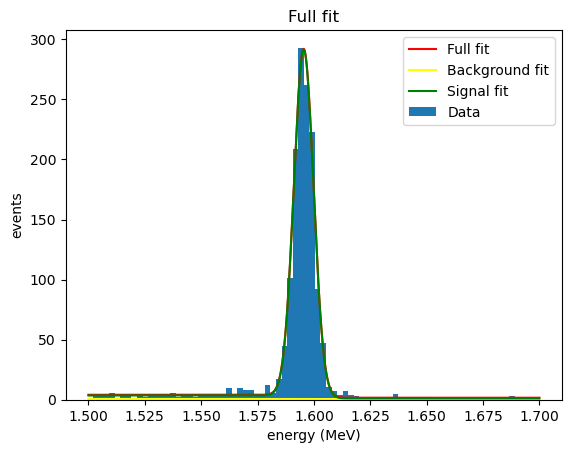

        Fitting output      
ns: 3.1652 ± 0.0291
a: 0.0083 ± 0.0157
nb: 1.4267 ± 35.3351
tau: 1.7585 ± 47.9180
ns - 1467.0892177595579
nb - 46.62434471679612
total = 1514
Event no = 1510
fom - 3.18 ± 0.26
e - 0.56 ± 0.02
b - 0.03 ± 0.00
Applying cut 0.26 MeV
=========================== GAUSSIAN FIT ============================


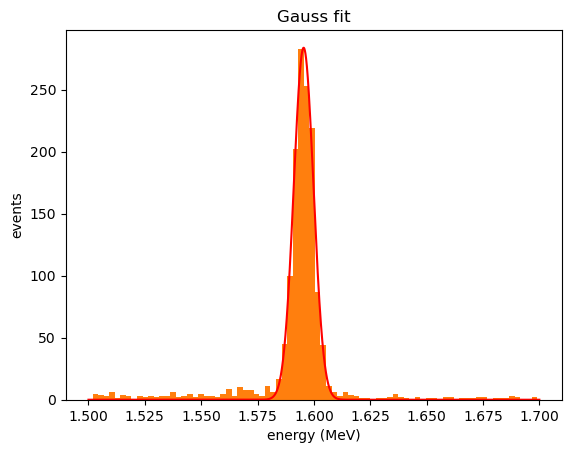

        Fitting output      
A: 283.7884 ± 3.7514
mu: 1.5954 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


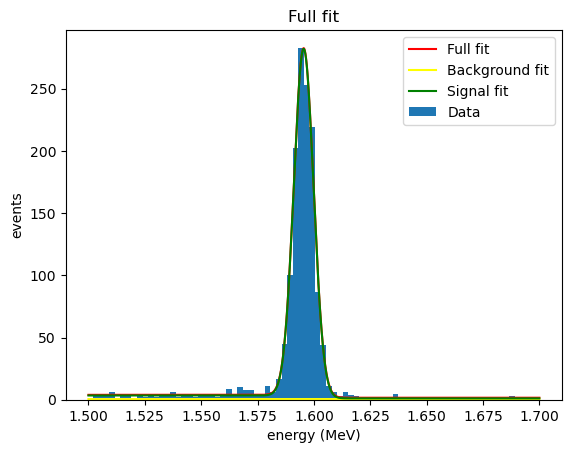

        Fitting output      
ns: 3.0716 ± 0.0298
a: 0.0083 ± 0.0164
nb: 0.5283 ± 14.5002
tau: -7489.4137 ± 960583001.4172
ns - 1423.6759930663834
nb - 42.87258376241301
total = 1467
Event no = 1463
fom - 3.22 ± 0.27
e - 0.55 ± 0.02
b - 0.03 ± 0.00
Applying cut 0.27 MeV
=========================== GAUSSIAN FIT ============================


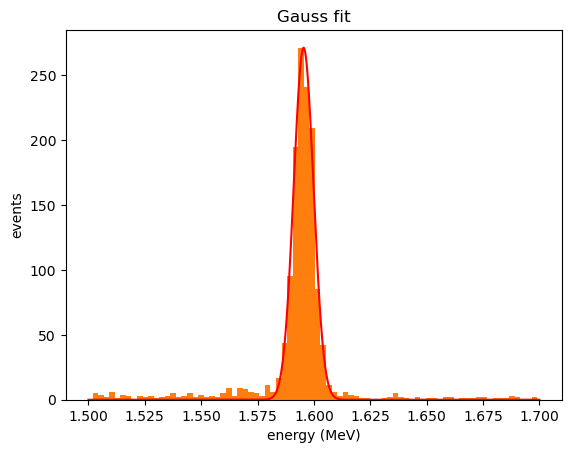

        Fitting output      
A: 271.1281 ± 3.5750
mu: 1.5954 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


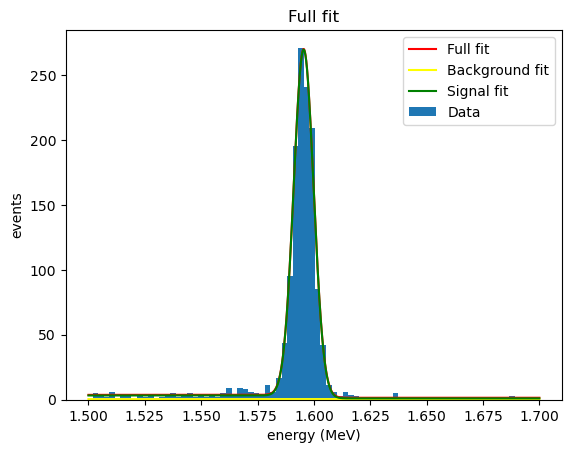

        Fitting output      
ns: 2.9476 ± 0.0285
a: 0.0083 ± 0.0165
nb: 0.4839 ± 13.9401
tau: 992.3722 ± 17703653.0040
ns - 1366.1774759594748
nb - 39.20049589902838
total = 1405
Event no = 1402
fom - 3.23 ± 0.28
e - 0.52 ± 0.02
b - 0.03 ± 0.00
Applying cut 0.28 MeV
=========================== GAUSSIAN FIT ============================


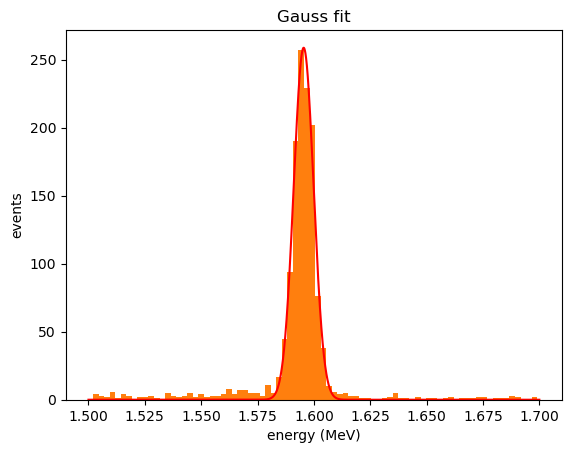

        Fitting output      
A: 258.7591 ± 3.6050
mu: 1.5955 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


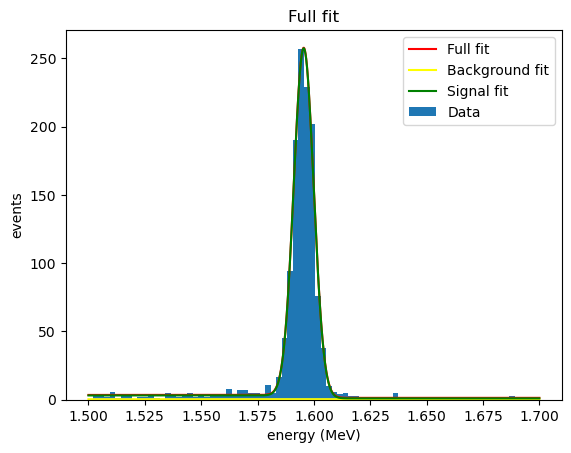

        Fitting output      
ns: 2.8227 ± 0.0299
a: 0.0084 ± 0.0179
nb: 0.3803 ± 14.4988
tau: 8041.4659 ± 1538035998.6172
ns - 1309.5197880059204
nb - 30.881352003667004
total = 1340
Event no = 1337
fom - 3.49 ± 0.34
e - 0.50 ± 0.02
b - 0.02 ± 0.00
Applying cut 0.29000000000000004 MeV
=========================== GAUSSIAN FIT ============================


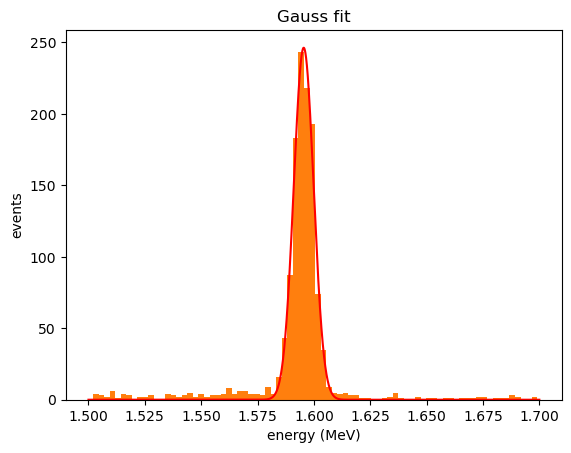

        Fitting output      
A: 246.3405 ± 3.4194
mu: 1.5955 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


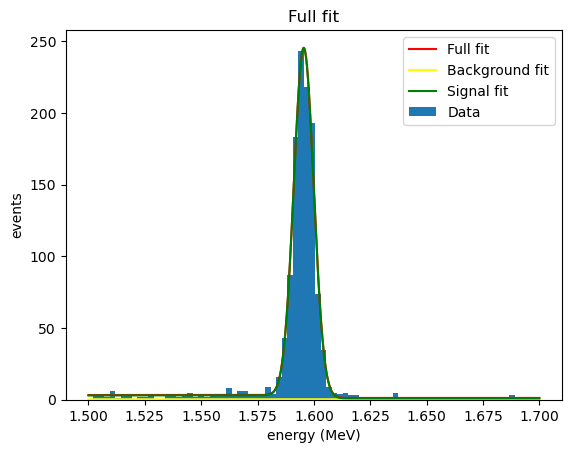

        Fitting output      
ns: 2.6868 ± 0.0285
a: 0.0084 ± 0.0181
nb: 0.3036 ± 13.7090
tau: 14375.1612 ± 5819343409.1339
ns - 1246.510185469947
nb - 24.654996597552394
total = 1271
Event no = 1268
fom - 3.72 ± 0.40
e - 0.48 ± 0.02
b - 0.02 ± 0.00
Applying cut 0.3 MeV
=========================== GAUSSIAN FIT ============================


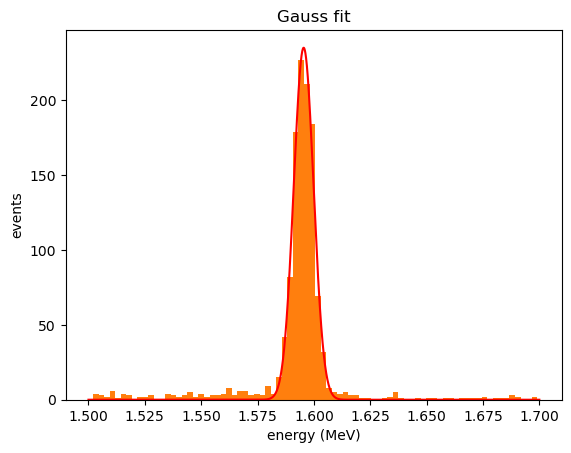

        Fitting output      
A: 235.2139 ± 3.3288
mu: 1.5955 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


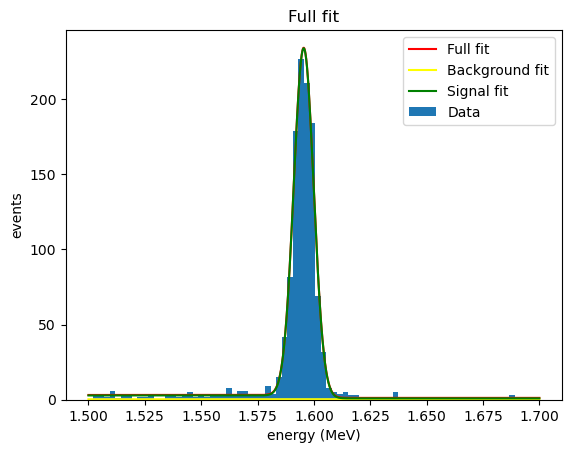

        Fitting output      
ns: 2.5625 ± 0.0276
a: 0.0083 ± 0.0183
nb: 0.3235 ± 13.4574
tau: 3648.5645 ± 345590076.1689
ns - 1188.8001497547616
nb - 26.259753890396162
total = 1215
Event no = 1212
fom - 3.44 ± 0.36
e - 0.46 ± 0.02
b - 0.02 ± 0.00
Applying cut 0.31 MeV
=========================== GAUSSIAN FIT ============================


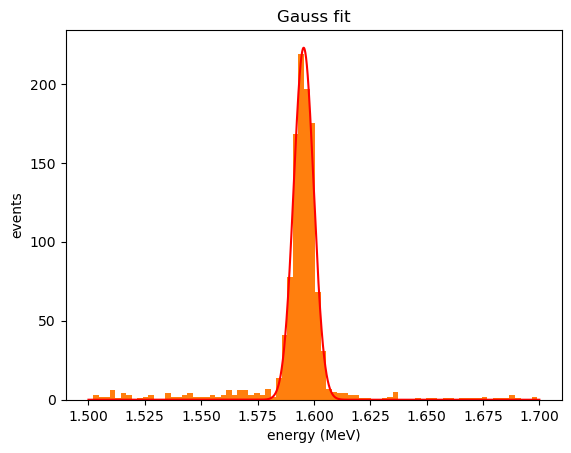

        Fitting output      
A: 222.8784 ± 3.1102
mu: 1.5955 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


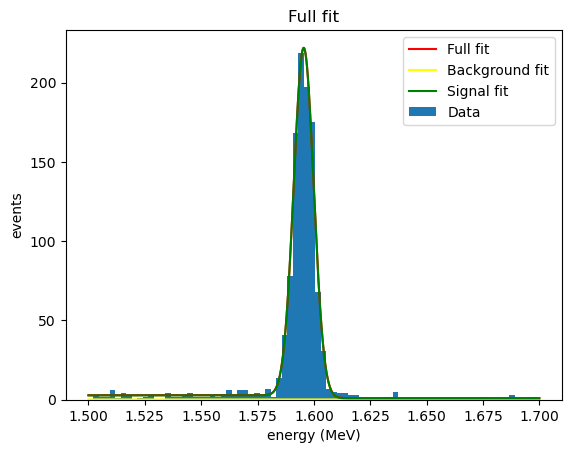

        Fitting output      
ns: 2.4408 ± 0.0264
a: 0.0084 ± 0.0184
nb: 0.1648 ± 12.8588
tau: 5313.2592 ± 1374711923.3640
ns - 1132.3637254460791
nb - 13.378298698620926
total = 1146
Event no = 1143
fom - 4.59 ± 0.65
e - 0.44 ± 0.02
b - 0.01 ± 0.00
Applying cut 0.32 MeV
=========================== GAUSSIAN FIT ============================


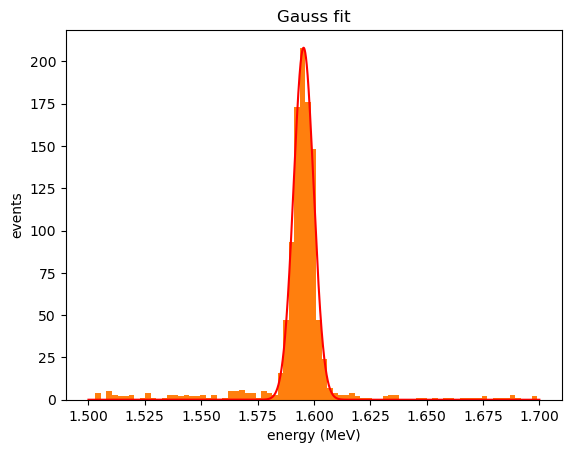

        Fitting output      
A: 208.1400 ± 2.8647
mu: 1.5954 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


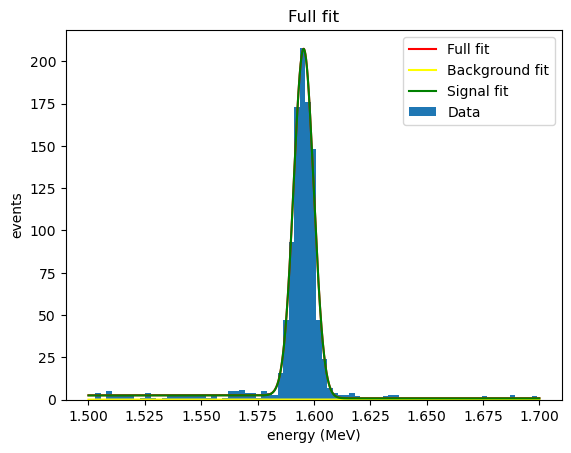

        Fitting output      
ns: 2.2866 ± 0.0247
a: 0.0084 ± 0.0189
nb: 0.0978 ± 2.7543
tau: -126124.2001 ± 276533135758.3012
ns - 1066.6972097191647
nb - 7.988467113852761
total = 1075
Event no = 1071
fom - 5.59 ± 1.01
e - 0.41 ± 0.01
b - 0.01 ± 0.00
Applying cut 0.33 MeV
=========================== GAUSSIAN FIT ============================


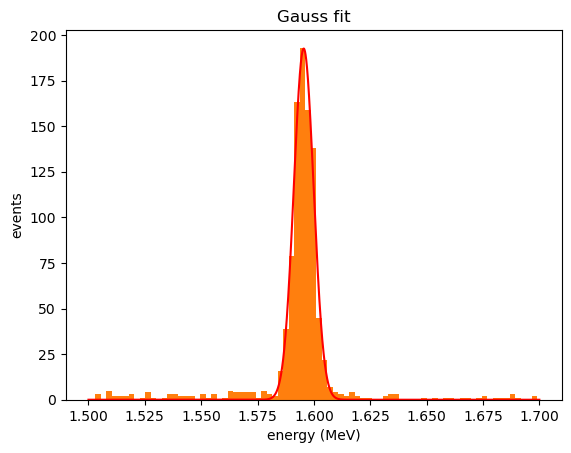

        Fitting output      
A: 192.5522 ± 2.9495
mu: 1.5955 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


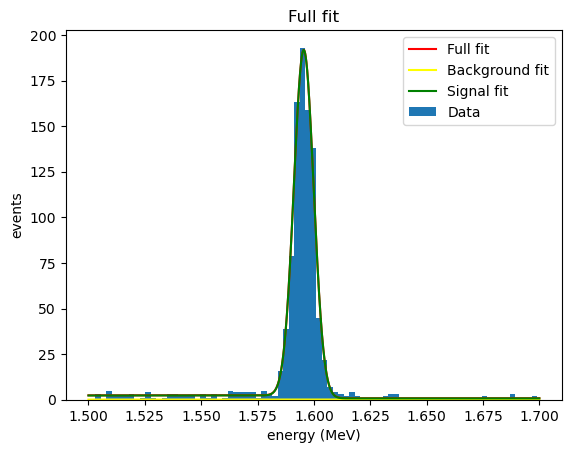

        Fitting output      
ns: 2.0909 ± 0.0265
a: 0.0083 ± 0.0213
nb: 0.0974 ± 12.0171
tau: -10481.7736 ± 8445179594.7376
ns - 975.4273164246649
nb - 7.956481483005134
total = 983
Event no = 980
fom - 5.12 ± 0.93
e - 0.37 ± 0.01
b - 0.01 ± 0.00
Applying cut 0.34 MeV
=========================== GAUSSIAN FIT ============================


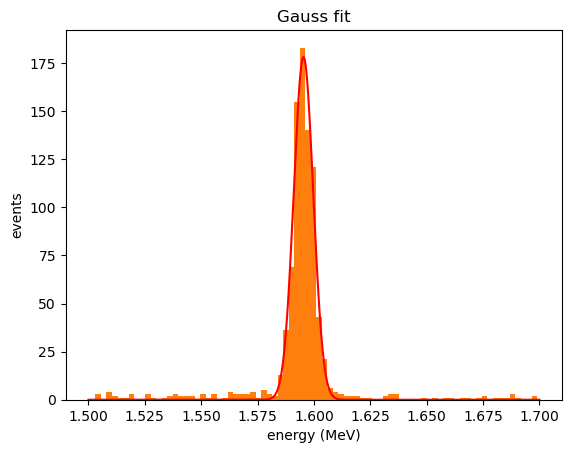

        Fitting output      
A: 178.1517 ± 2.9440
mu: 1.5954 ± 0.0001
sigma: 0.0043 ± 0.0001
=========================== FULL FIT ============================


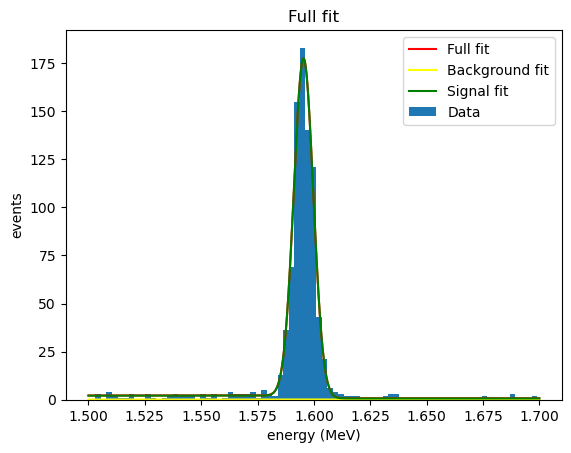

        Fitting output      
ns: 1.9054 ± 0.0260
a: 0.0082 ± 0.0231
nb: 0.1013 ± 12.4822
tau: 14714.9698 ± 16662092331.2574
ns - 888.83441484879
nb - 8.269537762894995
total = 897
Event no = 894
fom - 4.58 ± 0.82
e - 0.34 ± 0.01
b - 0.01 ± 0.00
Applying cut 0.35000000000000003 MeV
=========================== GAUSSIAN FIT ============================


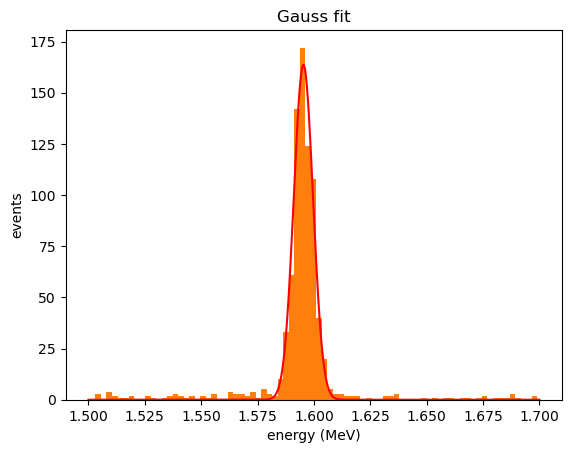

        Fitting output      
A: 163.6258 ± 2.9519
mu: 1.5953 ± 0.0001
sigma: 0.0043 ± 0.0001
=========================== FULL FIT ============================


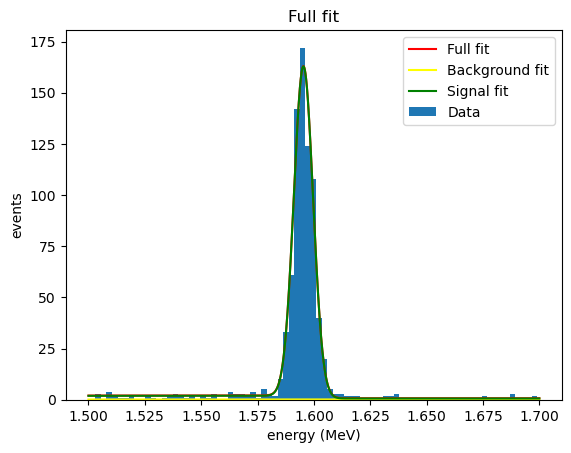

        Fitting output      
ns: 1.7269 ± 0.0260
a: 0.0081 ± 0.0254
nb: 0.1266 ± 12.9323
tau: 3979.4319 ± 1008453844.2881
ns - 805.5337850840066
nb - 10.336905603228733
total = 816
Event no = 813
fom - 3.71 ± 0.60
e - 0.31 ± 0.01
b - 0.01 ± 0.00
Applying cut 0.36000000000000004 MeV
=========================== GAUSSIAN FIT ============================


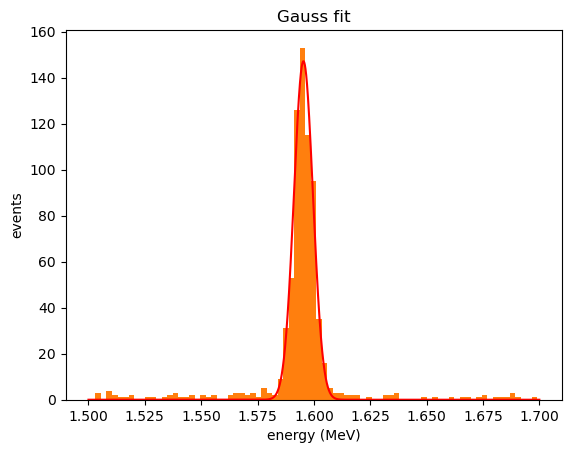

        Fitting output      
A: 147.1393 ± 2.4515
mu: 1.5954 ± 0.0001
sigma: 0.0042 ± 0.0001
=========================== FULL FIT ============================


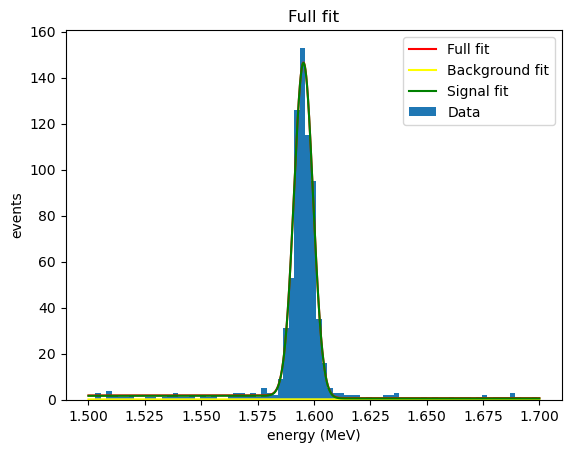

        Fitting output      
ns: 1.5378 ± 0.0209
a: 0.0080 ± 0.0231
nb: 0.1626 ± 10.3801
tau: 8114.2312 ± 2621570083.1359
ns - 717.3637266216936
nb - 13.275661454287631
total = 731
Event no = 728
fom - 2.92 ± 0.42
e - 0.28 ± 0.01
b - 0.01 ± 0.00
Applying cut 0.37 MeV
=========================== GAUSSIAN FIT ============================


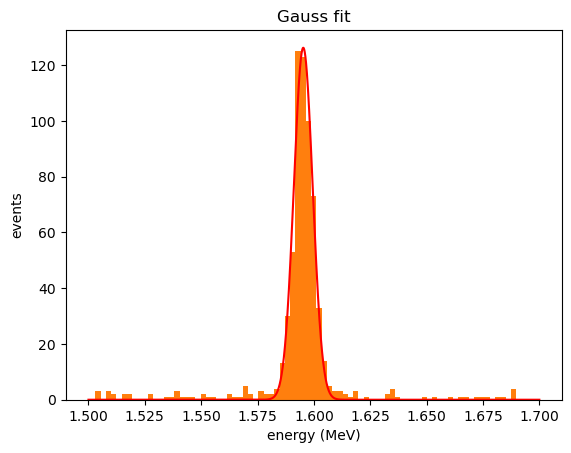

        Fitting output      
A: 126.2835 ± 2.2410
mu: 1.5953 ± 0.0001
sigma: 0.0042 ± 0.0001
=========================== FULL FIT ============================


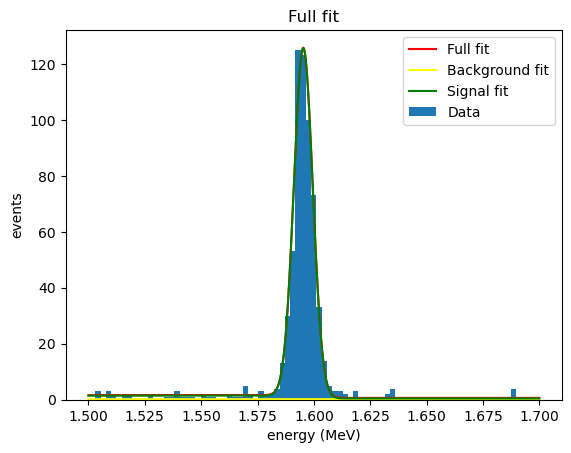

        Fitting output      
ns: 1.3059 ± 0.0191
a: 0.0079 ± 0.0250
nb: 0.1927 ± 10.0782
tau: 25445.7105 ± 21197628662.5079
ns - 639.5314726153391
nb - 16.518728866248622
total = 656
Event no = 651
fom - 2.33 ± 0.31
e - 0.25 ± 0.01
b - 0.01 ± 0.00
Applying cut 0.38 MeV
=========================== GAUSSIAN FIT ============================


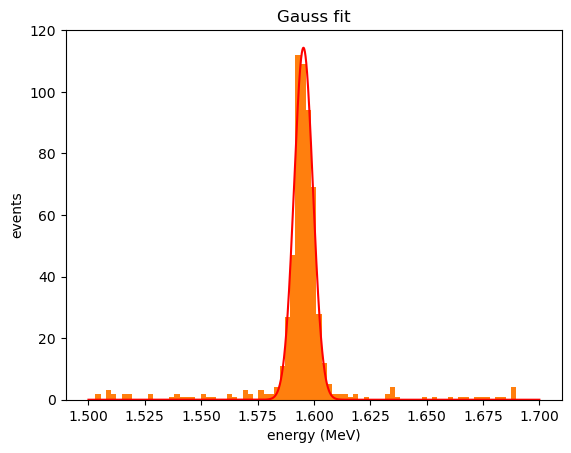

        Fitting output      
A: 114.3409 ± 1.9963
mu: 1.5954 ± 0.0001
sigma: 0.0042 ± 0.0001
=========================== FULL FIT ============================


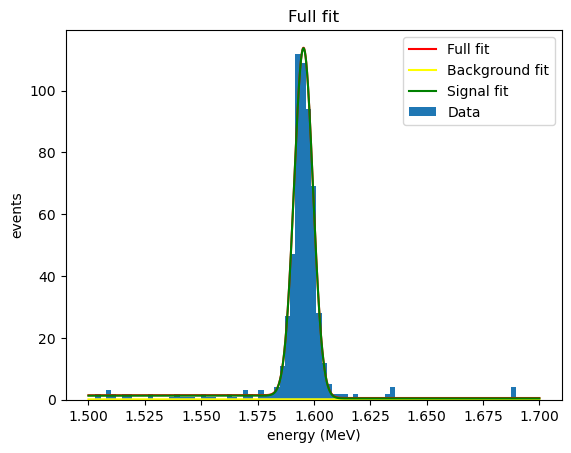

        Fitting output      
ns: 1.1835 ± 0.0171
a: 0.0079 ± 0.0245
nb: 0.1374 ± 9.1603
tau: 26061.3279 ± 28338140310.0914
ns - 579.5813388721286
nb - 11.78209708677757
total = 591
Event no = 587
fom - 2.50 ± 0.38
e - 0.22 ± 0.01
b - 0.01 ± 0.00
Applying cut 0.39 MeV
=========================== GAUSSIAN FIT ============================


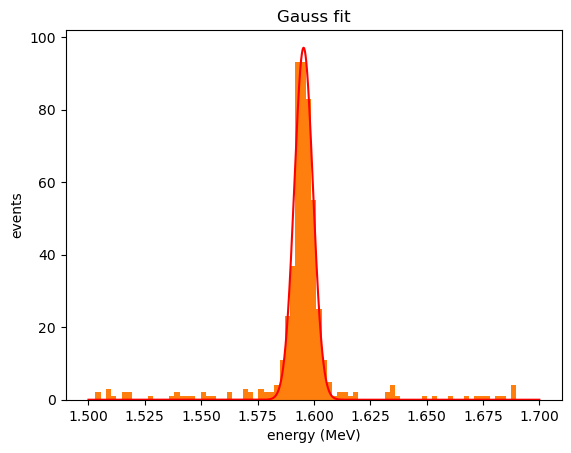

        Fitting output      
A: 97.0586 ± 1.7251
mu: 1.5954 ± 0.0001
sigma: 0.0041 ± 0.0001
=========================== FULL FIT ============================


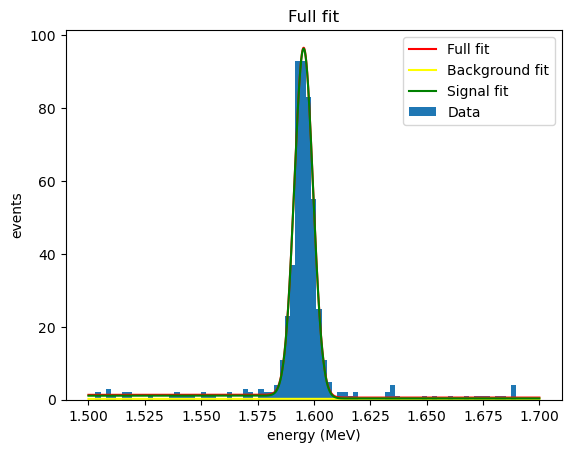

        Fitting output      
ns: 0.9940 ± 0.0143
a: 0.0079 ± 0.0245
nb: 0.2398 ± 5.9452
tau: 119385.2532 ± 221137488596.1655
ns - 486.81683794658886
nb - 20.561316500697153
total = 507
Event no = 503
fom - 1.59 ± 0.19
e - 0.19 ± 0.01
b - 0.01 ± 0.00
Applying cut 0.4 MeV
=========================== GAUSSIAN FIT ============================


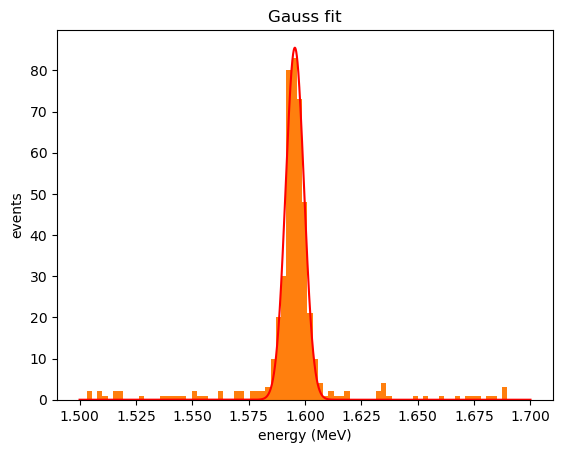

        Fitting output      
A: 85.5160 ± 1.5568
mu: 1.5955 ± 0.0001
sigma: 0.0041 ± 0.0001
=========================== FULL FIT ============================


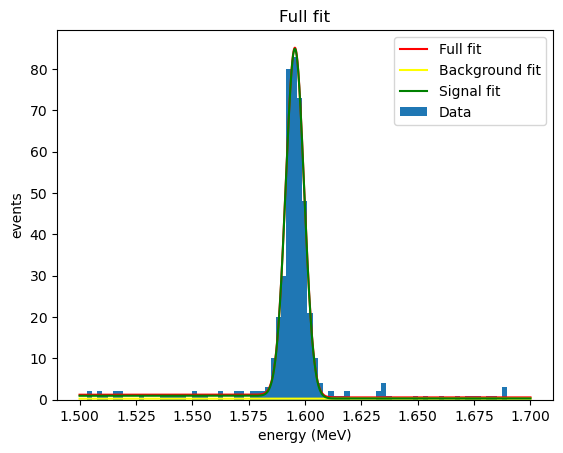

        Fitting output      
ns: 0.8591 ± 0.0126
a: 0.0077 ± 0.0251
nb: 0.2603 ± 6.5758
tau: 49591.2269 ± 38866947047.8340
ns - 420.7700763637661
nb - 22.317928173887967
total = 443
Event no = 439
fom - 1.32 ± 0.16
e - 0.16 ± 0.01
b - 0.02 ± 0.00
Applying cut 0.41000000000000003 MeV
=========================== GAUSSIAN FIT ============================


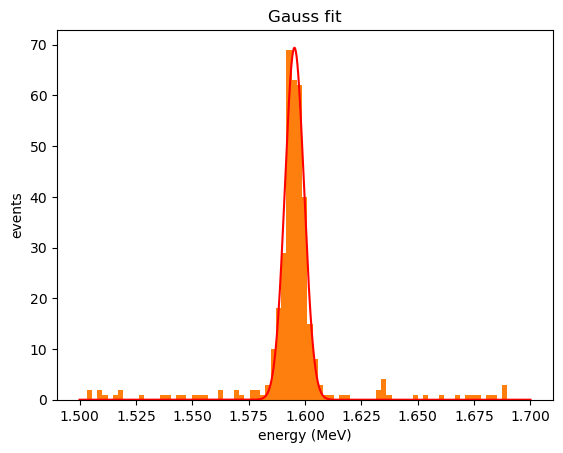

        Fitting output      
A: 69.4164 ± 1.4075
mu: 1.5953 ± 0.0001
sigma: 0.0042 ± 0.0001
=========================== FULL FIT ============================


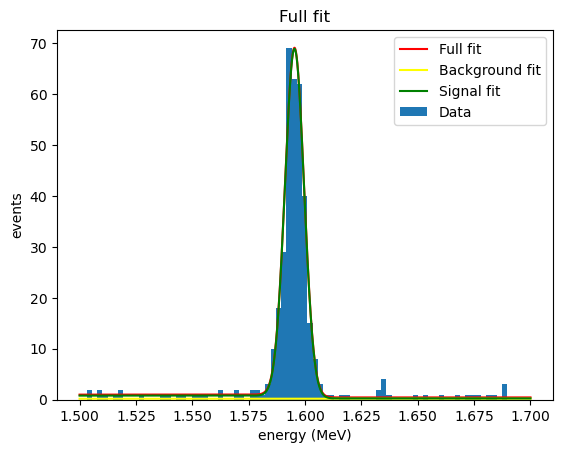

        Fitting output      
ns: 0.7256 ± 0.0121
a: 0.0080 ± 0.0283
nb: 0.1979 ± 6.4148
tau: 30591.2680 ± 18984548979.1583
ns - 355.36127490058095
nb - 16.965621783434596
total = 372
Event no = 369
fom - 1.28 ± 0.17
e - 0.14 ± 0.01
b - 0.01 ± 0.00
Applying cut 0.42000000000000004 MeV
=========================== GAUSSIAN FIT ============================


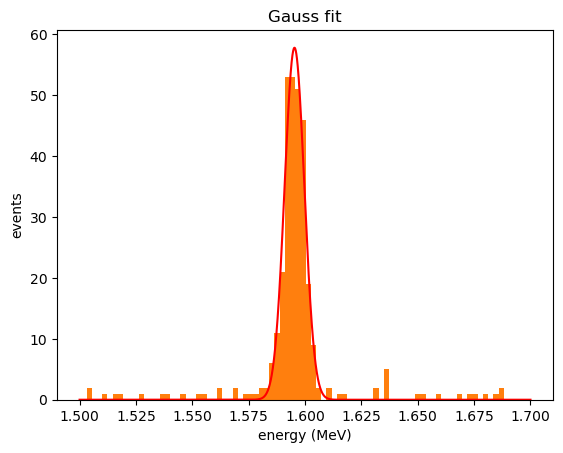

        Fitting output      
A: 57.7895 ± 1.2190
mu: 1.5953 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


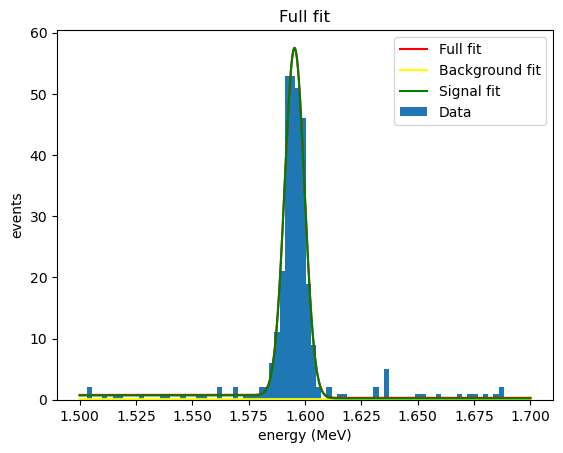

        Fitting output      
ns: 0.6255 ± 0.0112
a: 0.0083 ± 0.0303
nb: 0.0894 ± 5.7334
tau: 31585.2753 ± 40018004804.0129
ns - 308.8996399704494
nb - 7.729537165262025
total = 317
Event no = 314
fom - 1.65 ± 0.31
e - 0.12 ± 0.01
b - 0.01 ± 0.00
Applying cut 0.43 MeV
=========================== GAUSSIAN FIT ============================


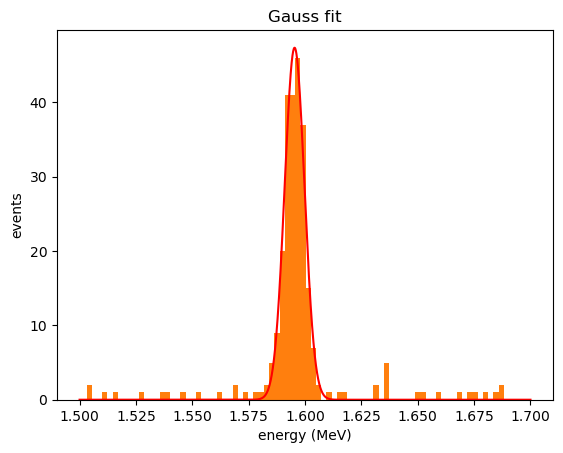

        Fitting output      
A: 47.3332 ± 0.9319
mu: 1.5954 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


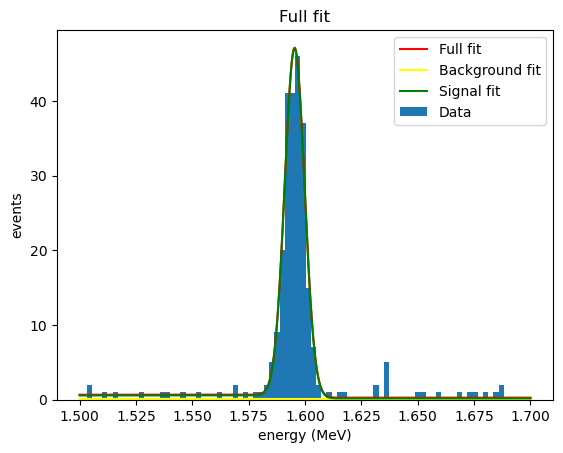

        Fitting output      
ns: 0.5142 ± 0.0094
a: 0.0083 ± 0.0278
nb: 0.0973 ± 4.3884
tau: 59566.2571 ± 100047976337.5638
ns - 253.90480217424079
nb - 8.409608089779109
total = 262
Event no = 260
fom - 1.30 ± 0.24
e - 0.10 ± 0.01
b - 0.01 ± 0.00
Applying cut 0.44 MeV
=========================== GAUSSIAN FIT ============================


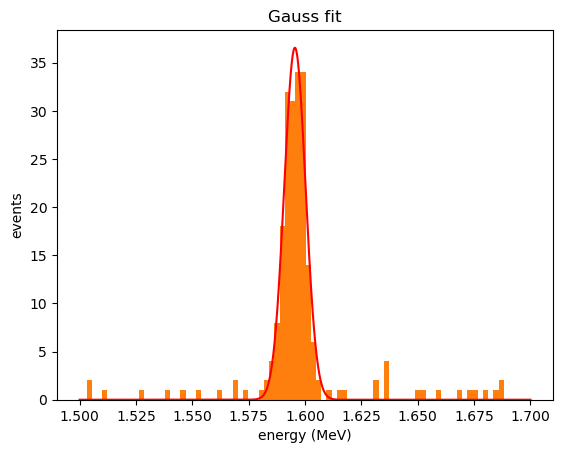

        Fitting output      
A: 36.5645 ± 0.8850
mu: 1.5955 ± 0.0001
sigma: 0.0047 ± 0.0001
=========================== FULL FIT ============================


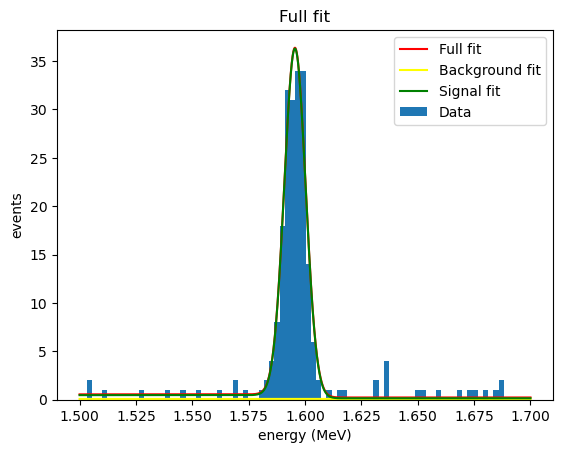

        Fitting output      
ns: 0.4268 ± 0.0088
a: 0.0090 ± 0.0348
nb: 0.0825 ± 0.1596
tau: 588924.2908 ± 0.0000
ns - 210.79987432959075
nb - 7.13273958820575
total = 218
Event no = 216
fom - 1.17 ± 0.23
e - 0.08 ± 0.01
b - 0.00 ± 0.00
Applying cut 0.45 MeV
=========================== GAUSSIAN FIT ============================


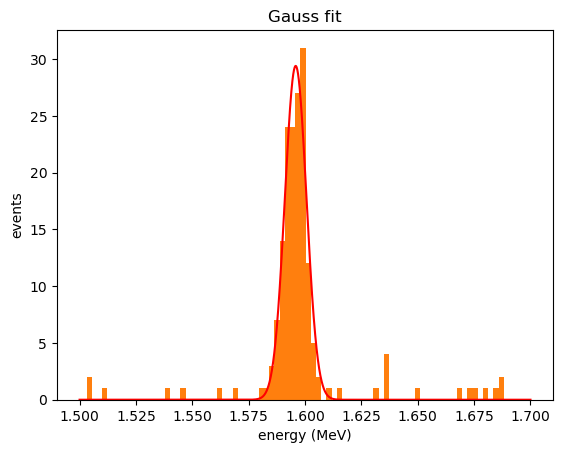

        Fitting output      
A: 29.3993 ± 0.8657
mu: 1.5958 ± 0.0002
sigma: 0.0048 ± 0.0002
=========================== FULL FIT ============================


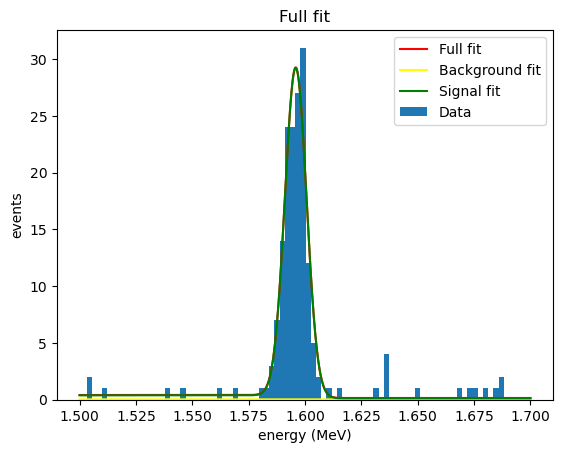

        Fitting output      
ns: 0.3476 ± 0.0088
a: 0.0091 ± 0.0430
nb: 0.0306 ± 4.4626
tau: 9522.7925 ± 8287832865.8493
ns - 171.69343023196853
nb - 2.644219206182502
total = 174
Event no = 173
fom - 1.56 ± 0.50
e - 0.07 ± 0.01
b - 0.00 ± 0.00
Applying cut 0.46 MeV
=========================== GAUSSIAN FIT ============================


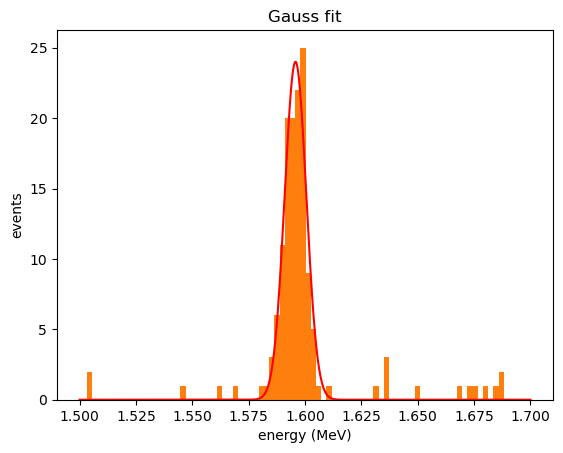

        Fitting output      
A: 24.0018 ± 0.7125
mu: 1.5958 ± 0.0002
sigma: 0.0048 ± 0.0002
=========================== FULL FIT ============================


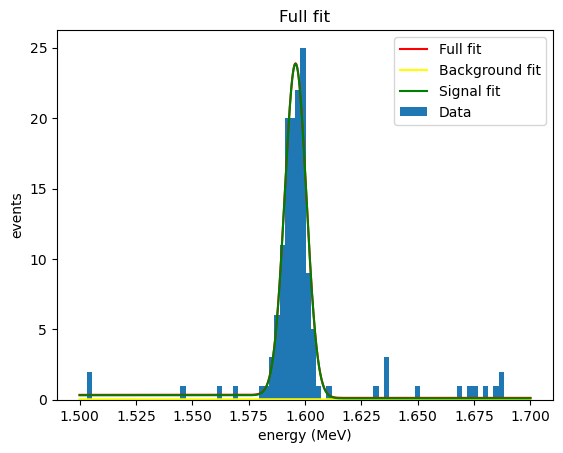

        Fitting output      
ns: 0.2843 ± 0.0073
a: 0.0091 ± 0.0435
nb: 0.0315 ± 3.3401
tau: 28374.6055 ± 53474792582.5757
ns - 140.41531120317563
nb - 2.720349714965394
total = 143
Event no = 142
fom - 1.26 ± 0.40
e - 0.05 ± 0.00
b - 0.00 ± 0.00
Applying cut 0.47000000000000003 MeV
=========================== GAUSSIAN FIT ============================


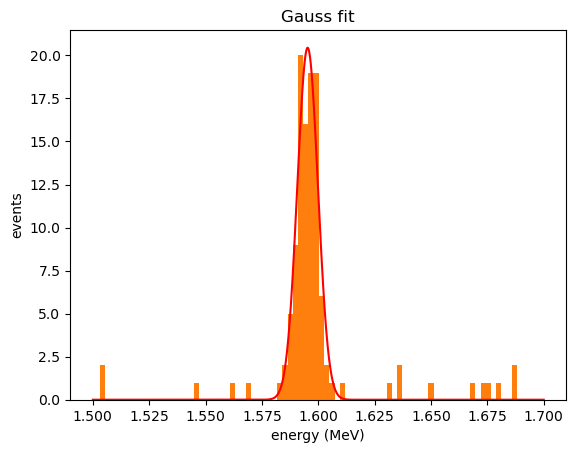

        Fitting output      
A: 20.4448 ± 0.6844
mu: 1.5953 ± 0.0002
sigma: 0.0046 ± 0.0002
=========================== FULL FIT ============================


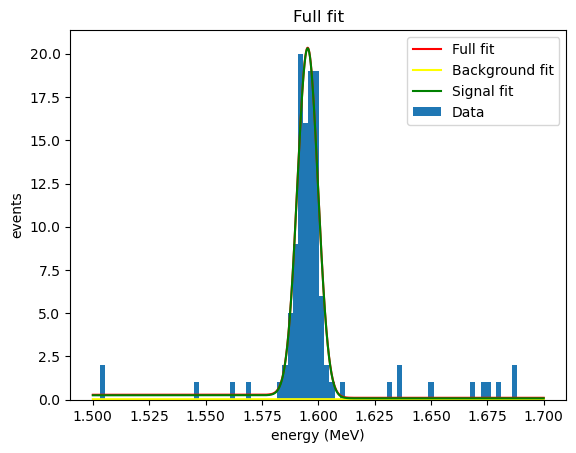

        Fitting output      
ns: 0.2315 ± 0.0067
a: 0.0087 ± 0.0490
nb: 0.0307 ± 3.3446
tau: 33279.8326 ± 75453120485.2930
ns - 114.30360216414843
nb - 2.653862125129394
total = 117
Event no = 116
fom - 1.04 ± 0.33
e - 0.04 ± 0.00
b - 0.00 ± 0.00
Applying cut 0.48000000000000004 MeV
=========================== GAUSSIAN FIT ============================


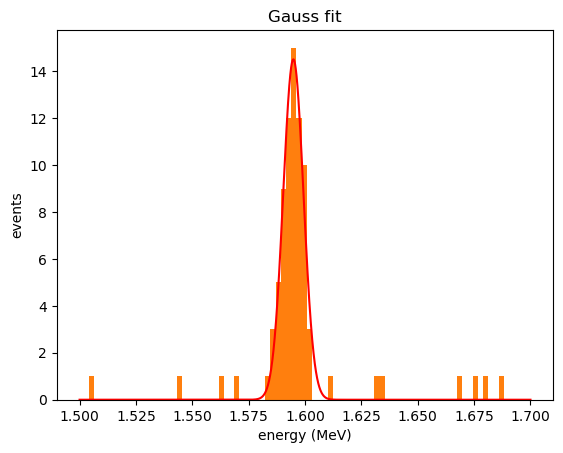

        Fitting output      
A: 14.5043 ± 0.3457
mu: 1.5948 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


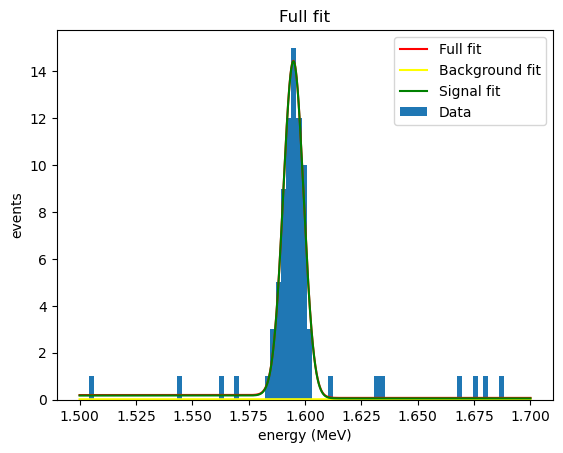

        Fitting output      
ns: 0.1609 ± 0.0033
a: 0.0085 ± 0.0343
nb: 0.0212 ± 1.6560
tau: 20552.1664 ± 20618191527.8662
ns - 79.91712167427599
nb - 1.8463395835008034
total = 82
Event no = 81
fom - 0.87 ± 0.34
e - 0.03 ± 0.00
b - 0.00 ± 0.00
Applying cut 0.49 MeV
=========================== GAUSSIAN FIT ============================


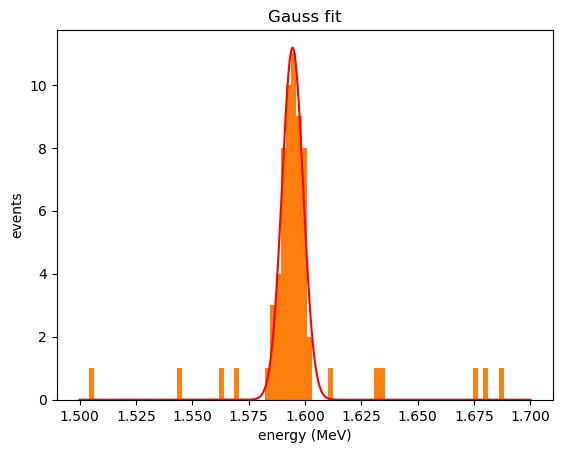

        Fitting output      
A: 11.1776 ± 0.3143
mu: 1.5945 ± 0.0002
sigma: 0.0047 ± 0.0002
=========================== FULL FIT ============================


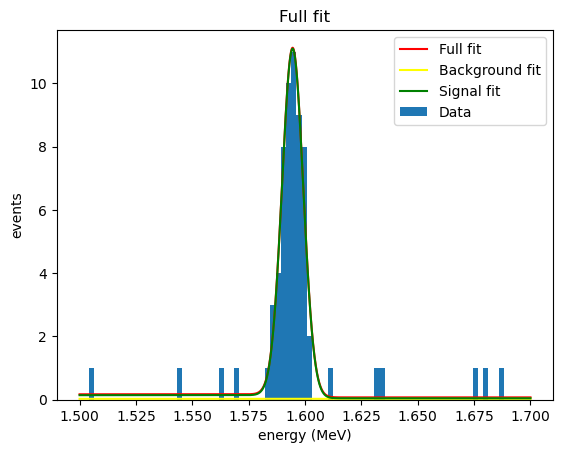

        Fitting output      
ns: 0.1293 ± 0.0031
a: 0.0089 ± 0.0405
nb: 0.0285 ± 0.0568
tau: -504239.8549 ± 0.0000
ns - 64.21188996519912
nb - 2.4815512517419576
total = 67
Event no = 66
fom - 0.60 ± 0.21
e - 0.02 ± 0.00
b - 0.00 ± 0.00
Applying cut 0.5 MeV
=========================== GAUSSIAN FIT ============================


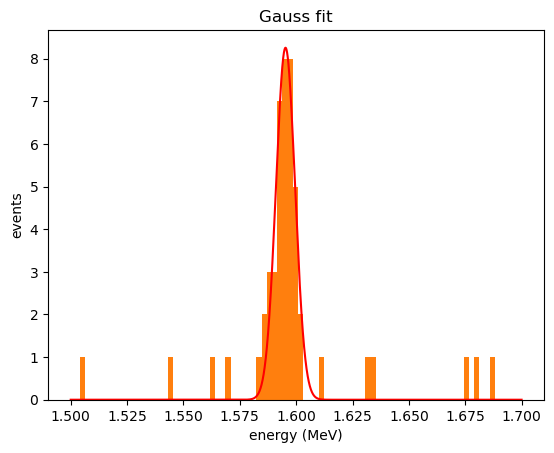

        Fitting output      
A: 8.2555 ± 0.3148
mu: 1.5953 ± 0.0002
sigma: 0.0042 ± 0.0002
=========================== FULL FIT ============================


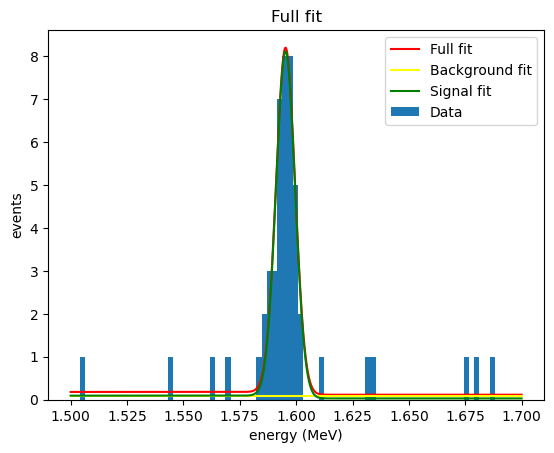

        Fitting output      
ns: 0.0854 ± 0.0027
a: 0.0080 ± 0.0542
nb: 0.0865 ± 0.0524
tau: -167153.9722 ± 0.0000
ns - 42.40710492874669
nb - 7.521517393134626
total = 50
Event no = 49
fom - 0.23 ± 0.05
e - 0.02 ± 0.00
b - 0.01 ± 0.00
Applying cut 0.51 MeV
=========================== GAUSSIAN FIT ============================


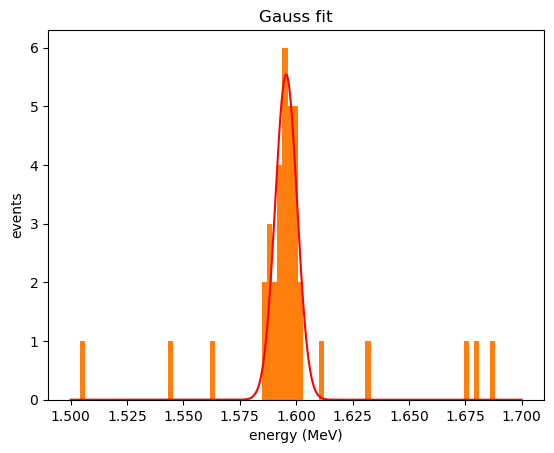

        Fitting output      
A: 5.5413 ± 0.2898
mu: 1.5956 ± 0.0003
sigma: 0.0049 ± 0.0003
=========================== FULL FIT ============================


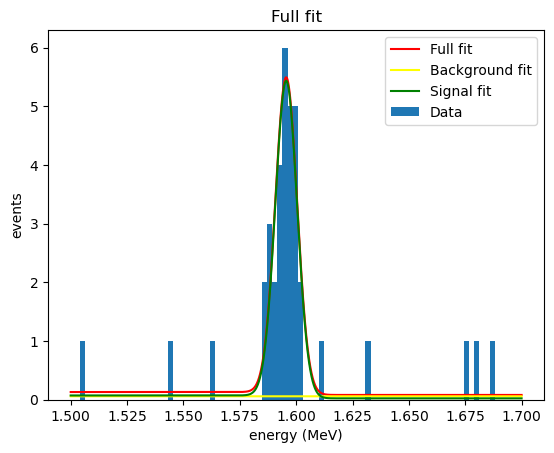

        Fitting output      
ns: 0.0656 ± 0.0030
a: 0.0092 ± 0.0765
nb: 0.0584 ± 1.5159
tau: 56132.6710 ± 51184586211.1295
ns - 32.577779399207465
nb - 5.079621859547672
total = 38
Event no = 37
fom - 0.21 ± 0.06
e - 0.01 ± 0.00
b - 0.00 ± 0.00
Applying cut 0.52 MeV
=========================== GAUSSIAN FIT ============================


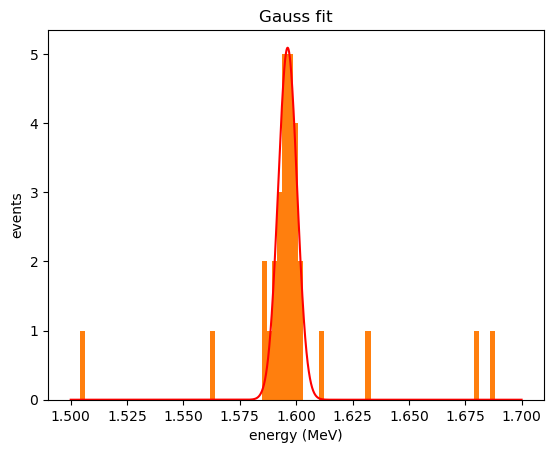

        Fitting output      
A: 5.0906 ± 0.2503
mu: 1.5962 ± 0.0002
sigma: 0.0042 ± 0.0002
=========================== FULL FIT ============================


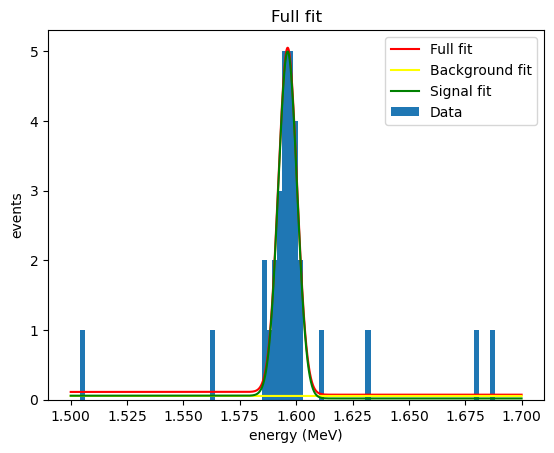

        Fitting output      
ns: 0.0521 ± 0.0022
a: 0.0080 ± 0.0714
nb: 0.0541 ± 1.2046
tau: 49897.2988 ± 34696966127.9060
ns - 25.87063938653919
nb - 4.705051407633194
total = 31
Event no = 30
fom - 0.18 ± 0.05
e - 0.01 ± 0.00
b - 0.00 ± 0.00
Applying cut 0.53 MeV
=========================== GAUSSIAN FIT ============================


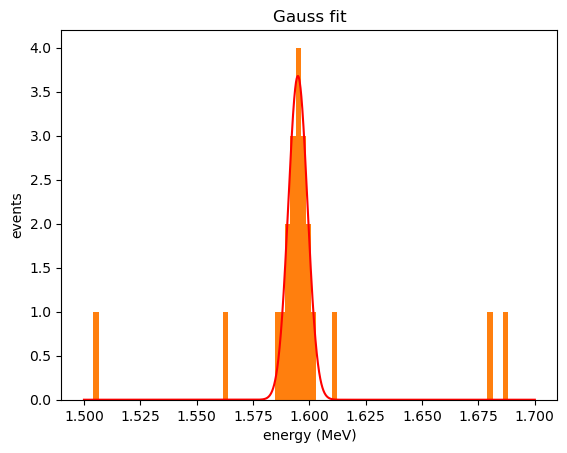

        Fitting output      
A: 3.6790 ± 0.1842
mu: 1.5949 ± 0.0002
sigma: 0.0042 ± 0.0002
=========================== FULL FIT ============================


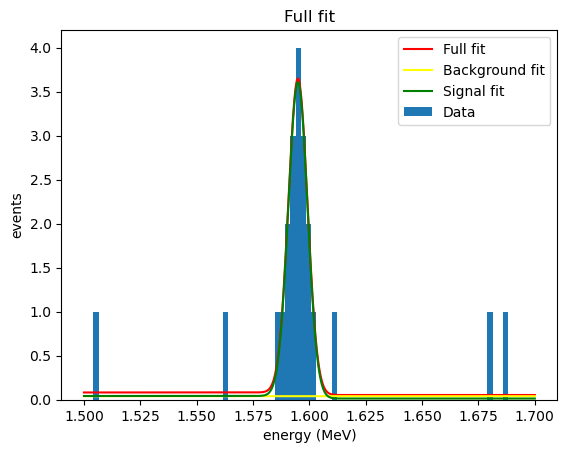

        Fitting output      
ns: 0.0381 ± 0.0016
a: 0.0081 ± 0.0728
nb: 0.0402 ± 0.0314
tau: 3026590.1698 ± 0.0000
ns - 18.93109694953535
nb - 3.494424023415978
total = 22
Event no = 22
fom - 0.15 ± 0.05
e - 0.01 ± 0.00
b - 0.00 ± 0.00
Applying cut 0.54 MeV
=========================== GAUSSIAN FIT ============================


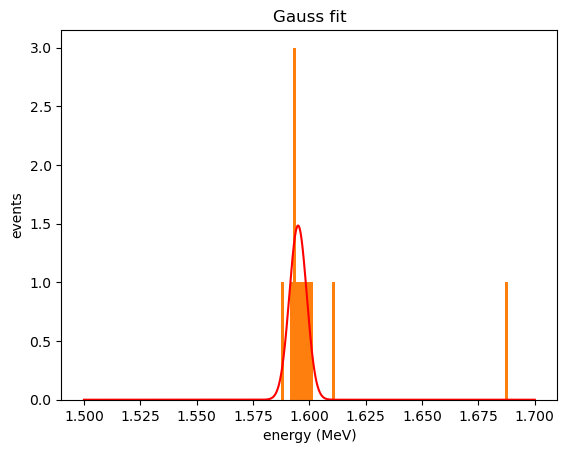

        Fitting output      
A: 1.4846 ± 0.1624
mu: 1.5950 ± 0.0005
sigma: 0.0038 ± 0.0005
=========================== FULL FIT ============================


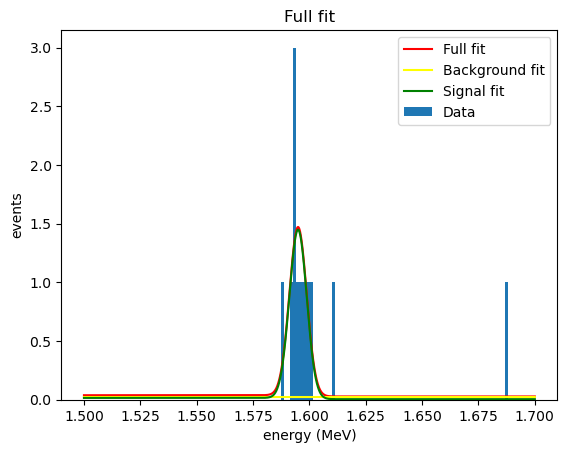

        Fitting output      
ns: 0.0138 ± 0.0013
a: 0.0020 ± 0.1641
nb: 0.0230 ± 0.0367
tau: -1005536.1616 ± 0.0000
ns - 12.562111624586898
nb - 3.666640807167187
total = 16
Event no = 13
fom - 0.10 ± 0.04
e - 0.00 ± 0.00
b - 0.00 ± 0.00
Applying cut 0.55 MeV
=========================== GAUSSIAN FIT ============================


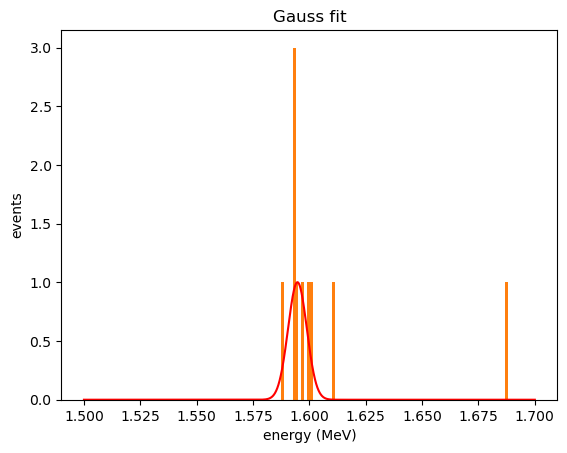

        Fitting output      
A: 1.0015 ± 0.1878
mu: 1.5947 ± 0.0009
sigma: 0.0042 ± 0.0010
=========================== FULL FIT ============================


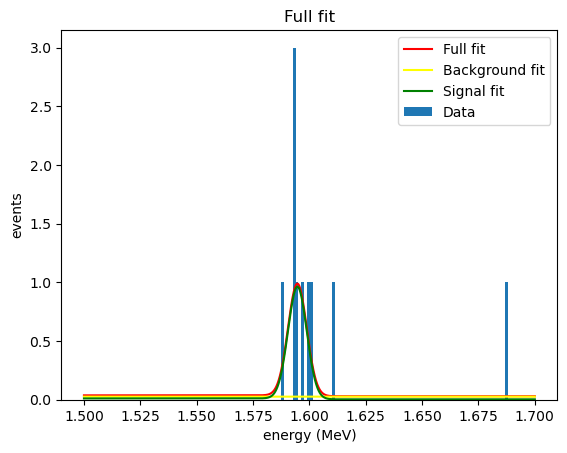

        Fitting output      
ns: 0.0100 ± 0.0017
a: -0.0033 ± 0.2882
nb: 0.0262 ± 0.0441
tau: 2692910.7756 ± 0.0000
ns - 9.045796015197649
nb - 4.175339162485355
total = 13
Event no = 10
fom - 0.07 ± 0.03
e - 0.00 ± 0.00
b - 0.00 ± 0.00
Applying cut 0.56 MeV
=========================== GAUSSIAN FIT ============================


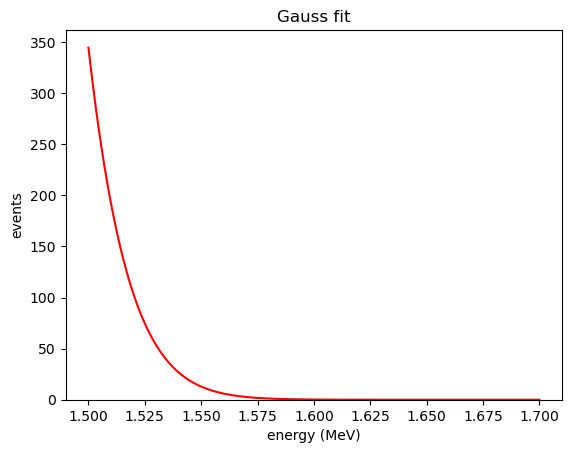

        Fitting output      
A: 27426.9855 ± 7617947.9153
mu: 1.3453 ± 6.0670
sigma: 0.0523 ± 0.6276
=========================== FULL FIT ============================


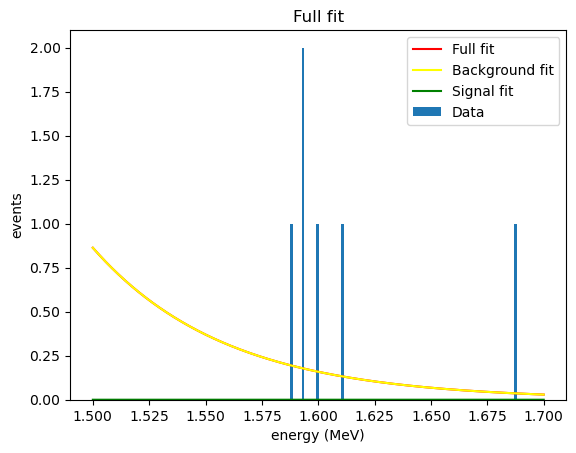

        Fitting output      
ns: 0.0000 ± 0.2310
a: -598.3574 ± 0.0000
nb: 93277630997.3065 ± 0.0000
tau: 0.0590 ± 0.0017
ns - 3.284533406619548e-32
nb - 39.17287436497431
total = 39
Event no = 6
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 0.03 ± 0.00
Applying cut 0.5700000000000001 MeV
=========================== GAUSSIAN FIT ============================


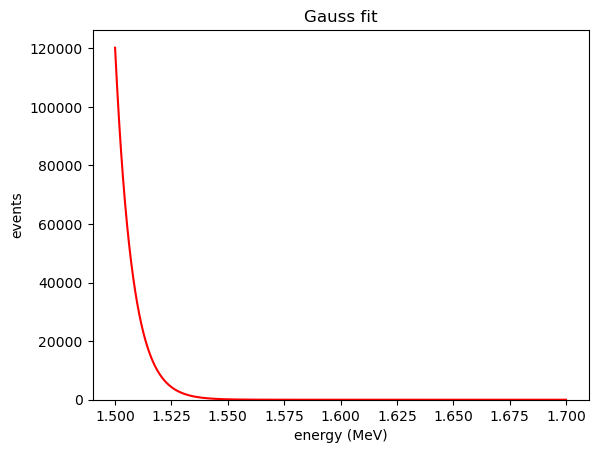

        Fitting output      
A: 26606594114082492157897211904.0000 ± 240000701402849984321482834051072.0000
mu: 0.6798 ± 124.6639
sigma: 0.0791 ± 5.3911
=========================== FULL FIT ============================


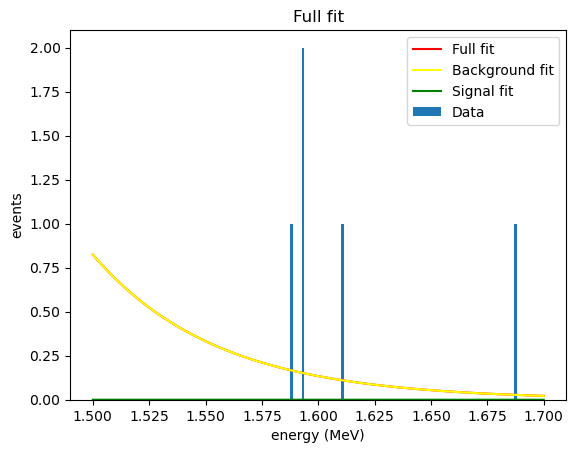

        Fitting output      
ns: 0.0000 ± 0.2070
a: 1.0510 ± 0.0000
nb: 556980179978.3594 ± 0.0000
tau: 0.0551 ± 0.0016
ns - 1.8668964859526702e-33
nb - 35.14179069761034
total = 35
Event no = 5
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 0.02 ± 0.00
Applying cut 0.5800000000000001 MeV
=========================== GAUSSIAN FIT ============================


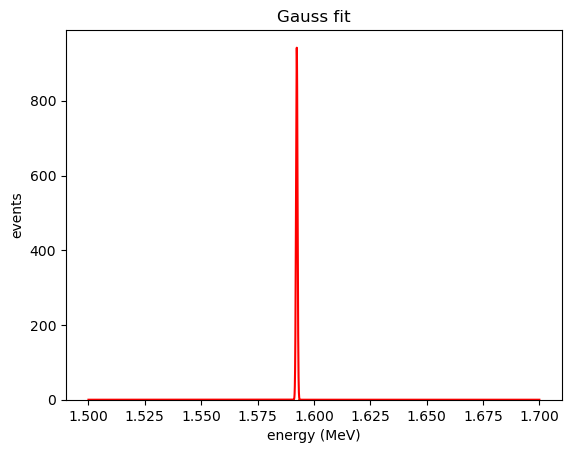

        Fitting output      
A: 941.9809 ± nan
mu: 1.5924 ± nan
sigma: 0.0003 ± 84.0469


/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1402: RuntimeWarning: invalid value encountered in sqrt
  print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors


=========================== FULL FIT ============================


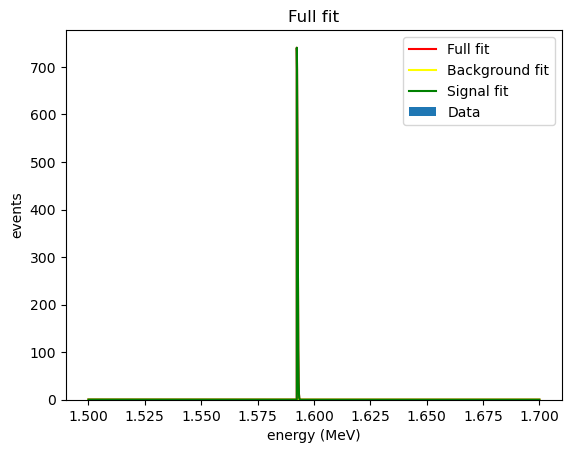

        Fitting output      
ns: 0.3128 ± 0.0298
a: 50922532476.9253 ± 0.0000
nb: 174337468095.1926 ± 0.0000
tau: 0.0014 ± 0.0000
ns - 299.7639896112343
nb - 0.0
total = 300
Event no = 4
fom - inf ± nan
e - 0.12 ± 0.01
b - 0.00 ± nan
Applying cut 0.59 MeV
=========================== GAUSSIAN FIT ============================


/tmp/ipykernel_12168/745896668.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  fom_check = e_check/np.sqrt(b_check)
/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1293: RuntimeWarning: invalid value encountered in double_scalars
  f_error = f*np.sqrt((a_error/a)**2 +(b_error/b)**2)
/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1313: RuntimeWarning: divide by zero encountered in double_scalars
  element_1 = np.square(a_error/np.sqrt(b))


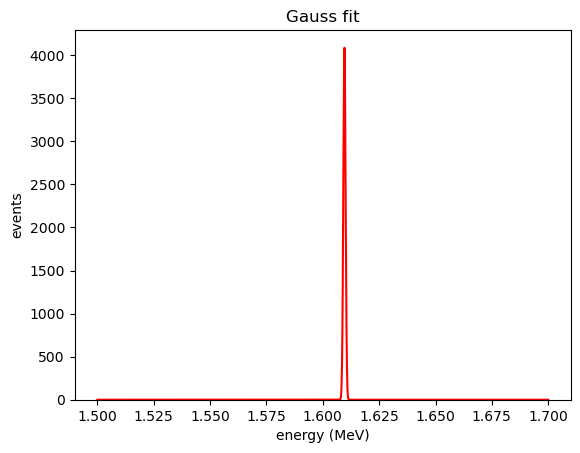

        Fitting output      
A: 4086.5779 ± nan
mu: 1.6096 ± nan
sigma: 0.0005 ± nan


/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1402: RuntimeWarning: invalid value encountered in sqrt
  print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors


=========================== FULL FIT ============================


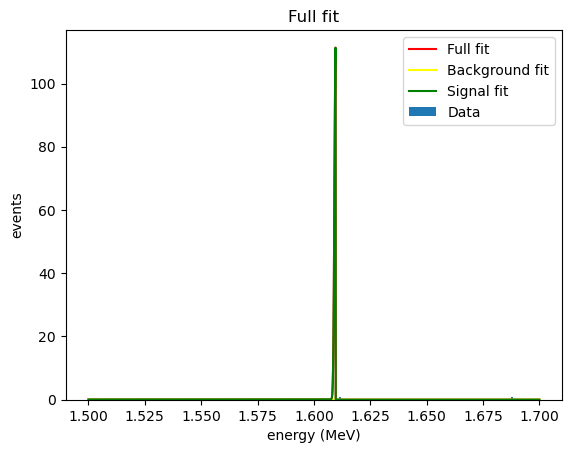

        Fitting output      
ns: 0.0710 ± 4149.3352
a: -56.2397 ± 0.0011
nb: 0.0000 ± 1420.6813
tau: 7.5685 ± 490866853.5859
ns - 85.05378950160073
nb - 0.0047057881444120975
total = 85
Event no = 2
fom - 18.37 ± 133.90
e - 0.03 ± 0.00
b - 0.00 ± 0.00
Applying cut 0.6 MeV
=========================== GAUSSIAN FIT ============================


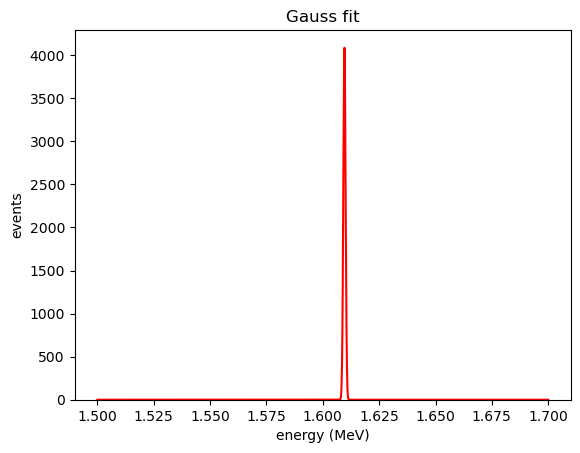

        Fitting output      
A: 4086.5779 ± nan
mu: 1.6096 ± nan
sigma: 0.0005 ± nan


/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1402: RuntimeWarning: invalid value encountered in sqrt
  print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors


=========================== FULL FIT ============================


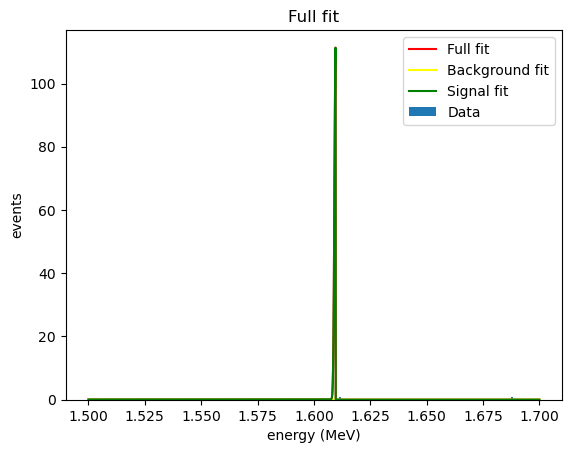

        Fitting output      
ns: 0.0710 ± 4149.3352
a: -56.2397 ± 0.0011
nb: 0.0000 ± 1420.6813
tau: 7.5685 ± 490866853.5859
ns - 85.05378950160073
nb - 0.0047057881444120975
total = 85
Event no = 2
fom - 18.37 ± 133.90
e - 0.03 ± 0.00
b - 0.00 ± 0.00
Applying cut 0.61 MeV
=========================== GAUSSIAN FIT ============================


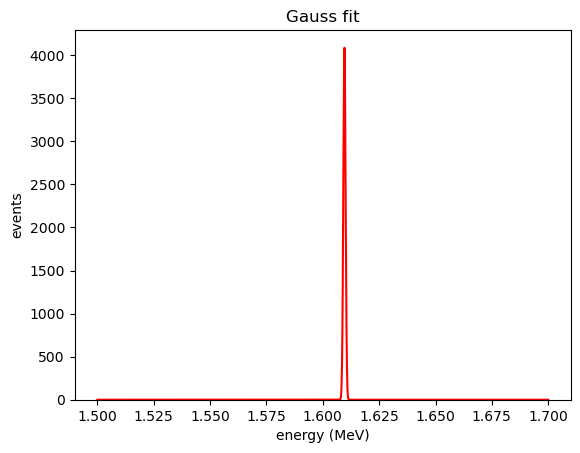

        Fitting output      
A: 4086.5779 ± nan
mu: 1.6096 ± nan
sigma: 0.0005 ± nan


/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1402: RuntimeWarning: invalid value encountered in sqrt
  print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors


=========================== FULL FIT ============================


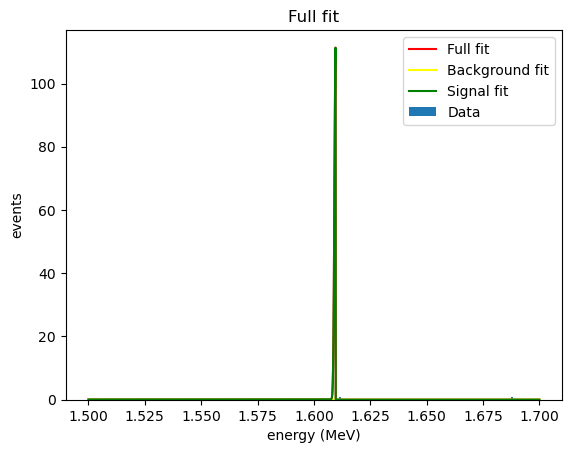

        Fitting output      
ns: 0.0710 ± 4149.3352
a: -56.2397 ± 0.0011
nb: 0.0000 ± 1420.6813
tau: 7.5685 ± 490866853.5859
ns - 85.05378950160073
nb - 0.0047057881444120975
total = 85
Event no = 2
fom - 18.37 ± 133.90
e - 0.03 ± 0.00
b - 0.00 ± 0.00


In [80]:
fom_out = fom_calc_MC(cut_tracks, pos_events, cut_list, verbose = True)

Try the fitting, but only do ns and take nb = nt - ns

In [97]:


def fom_calc_MC_sigonlyfit(cut_data, positron_data, cut_list, binning = 80, verbose = False):
    '''
        calculate FOM via fitting using MC information for C1 and C2
        start the cut list at non-zero. eg cut_list = [0.1, 0.2, ...]
    '''
    # preset some parameters for sanity purposes
    emin = 1.5
    emax = 1.7


    # select only events in which events have positrons
    sig_data = cut_data[cut_data['event'].isin(positron_data['event_id'].to_numpy())]
    bck_data = cut_data[~cut_data['event'].isin(positron_data['event_id'].to_numpy())]


    print("Obtaining C1 and C2")
    #####            C1 AND C2 ACQUISITION          #####
    # p0 is apriori
    p0 = ([1, 1, 1.58, 0.3, 0.8, 0])
    fit_labels = ['B1', 'A', 'mu', 'sigma', 'C1', 'C2']
    
    # fit the histogram
    s_popt, s_pcov = histogram_fit(func.sig_func, sig_data, binning, p0, fit_labels)

    
    if (verbose == True):
        print("=========================== SIGNAL FIT ============================")
        func.plot_fit(func.sig_func, np.linspace(emin, emax, 1000), s_popt, fit_labels)
        func.plot_hist(sig_data, binning = 80, title='Signal fit', log = False)
        plt.show()
        func.print_parameters(s_popt, s_pcov, fit_labels)
    
    # Set C1 and C2
    C1 = s_popt[4]
    C2 = s_popt[5]

    # C1 and C2 control
    if (C1 < 0):
        C1 = 0
    if (C2 < 0):
        C2 = 0

    print("C1: {}, C2: {}".format(C1, C2))



    #####           MU AND SIGMA ACQUISITION            #####

    # apriori
    g_p0 = [500, 1.6, 0.01]
    g_labels = ['A', 'mu', 'sigma']

    # collect histogram information

    #cnt, edges, patches = func.plot_hist(cut_data, binning = binning, log = False, data = True)
    # fit
    #g_popt, g_pcov = curve_fit(func.gauss, centres, cnts, g_p0, maxfev = 500000)
    g_popt, g_pcov = histogram_fit(func.gauss, cut_data, binning, g_p0, g_labels)
    # set mu and sigma
    mu      = g_popt[1]
    sigma   = g_popt[2]

    print("mu: {}, sigma: {}".format(mu, sigma))

    if (verbose == True):
        print("=========================== GAUSSIAN FIT ============================")
        func.plot_fit(func.gauss, np.linspace(emin, emax, 1000), g_popt, g_labels)
        func.plot_hist(cut_data, binning = 80, title='Gauss fit', log = False)
        plt.show()
        func.print_parameters(g_popt, g_pcov, g_labels)


    #####          NS AND NB ACQUISITION                #####
    fixed_sig_func = lambda x, ns, a: func.sig_func(x, ns, a, mu, sigma, C1, C2)
    #fixed_sig_bck_func = lambda x, ns, a, nb, tau: func.sig_bck_func(x, ns, a, mu, sigma, C1, C2, nb, tau)

    # apriori
    sb_p0 = [400, 1]
    sb_labels = ['ns', 'a']

    # fit
    sb_popt, sb_pcov = histogram_fit(fixed_sig_func, cut_data, binning, sb_p0, sb_labels)
    #sb_popt, sb_pcov = curve_fit(fixed_sig_bck_func, centres, cnts, sb_p0, maxfev = 500000)
    # take bin widths to calculate number of events
    _, edges, _ =func.plot_hist(cut_data, binning = binning, log = False, data = True)
    bin_width = edges[1] - edges[0]
    ns0 = quad(func.sig_func, emin, emax, args = (sb_popt[0],sb_popt[1], mu, sigma, C1, C2))/bin_width
    nb0 = len(cut_data.index) - ns0[0]
    #nb0 = quad(func.bck_func, emin, emax, args = (sb_popt[2], sb_popt[3]))/bin_width

    if (verbose == True):

        print("=========================== FULL FIT ============================")
        func.plot_fit(fixed_sig_bck_func, np.linspace(emin, emax, 1000), sb_popt, sb_labels)
        func.plot_hist(cut_data, binning = 80, title='Full fit', log = False)
        plt.show()
        func.print_parameters(sb_popt, sb_pcov, sb_labels)

        print('ns0      = {}'.format(ns0[0]))
        print('nb0      = {}'.format(nb0))
        print("total    = {:.0f}".format(ns0[0]+nb0))
        print("Event no = {}".format(len(cut_data.index)))
    
    
    # create list for fom values
    e       = []
    b       = []
    ns_l      = []
    nb_l      = []
    fom     = []
    fom_err = []
    e_err = []
    b_err = []

    ns_l.append(ns0[0])
    nb_l.append(nb0)

    # wipe variables to stop variable bleed over
    del g_popt, g_pcov, mu, sigma, sb_popt, sb_pcov, bin_width

    if (verbose == True):
        print("=========================== ====================== ===========================")
        print("=========================== BLOB 2 CUT STARTS HERE ===========================")
        print("=========================== ====================== ===========================")

    for i in range(len(cut_list)):

        print("Applying cut {} MeV".format(cut_list[i]))

        blob_data = cut_data[(cut_data['eblob2'] > cut_list[i])]

        # collect gaussian peak
        g_popt, g_pcov = histogram_fit(func.gauss, blob_data, binning, g_p0, g_labels)
        # set mu and sigma
        mu      = g_popt[1]
        sigma   = g_popt[2]

        if (verbose == True):
            print("=========================== GAUSSIAN FIT ============================")
            func.plot_fit(func.gauss, np.linspace(emin, emax, 1000), g_popt, g_labels)
            func.plot_hist(blob_data, binning = 80, title='Gauss fit', log = False)
            plt.show()
            func.print_parameters(g_popt, g_pcov, g_labels)

        # collect nb and ns
        sb_popt, sb_pcov = histogram_fit(fixed_sig_func, blob_data, binning, sb_p0, sb_labels, bounds = ([0, -np.inf],[np.inf, np.inf]))
        # take bin widths to calculate number of events
        _, edges, _ =func.plot_hist(blob_data, binning = binning, log = False, data = True, output = False)
        bin_width = edges[1] - edges[0]
        ns = quad(func.sig_func, emin, emax, args = (sb_popt[0],sb_popt[1], mu, sigma, C1, C2))/bin_width
        nb =  len(blob_data.index) - ns[0]
        ns_l.append(ns[0])
        nb_l.append(nb)
        if (verbose == True):

            print("=========================== FULL FIT ============================")
            plt.clf()
            func.plot_fit(fixed_sig_bck_func, np.linspace(emin, emax, 1000), sb_popt, sb_labels, lgnd='Full fit')
            #func.plot_fit(func.bck_func, np.linspace(emin, emax, 1000), sb_popt[-2:], sb_labels[-2:], lgnd='Background fit', colour = 'yellow')#, linestyle = 'dashed')

            # collect all sb_vales
            s_popt = [sb_popt[0], sb_popt[1], mu, sigma, C1, C2]
            s_labels = ['ns', 'a', 'mu', 'sigma', 'C1', 'C2']
            func.plot_fit(func.sig_func, np.linspace(emin, emax, 1000), s_popt, s_labels, lgnd='Signal fit', colour= 'green')#, linestyle = 'dashed')
            
            
            func.plot_hist(blob_data, binning = 80, title='Full fit', log = False, label = 'Data')
            plt.legend()
            plt.show()
            func.print_parameters(sb_popt, sb_pcov, sb_labels)

            print('ns - {}'.format(ns[0]))
            print('nb - {}'.format(nb))
            print("total = {:.0f}".format(ns[0]+nb))
            print("Event no = {}".format(len(blob_data.index)))
        
        e_check = ns[0]/ns0[0]
        b_check = nb/nb0
        fom_check = e_check/np.sqrt(b_check)

        e.append(e_check)
        b.append(b_check)
        fom.append(fom_check)

        # errors for fom
        e_err.append(func.ratio_error(e[i],ns[0],ns0[0],np.sqrt(ns[0]),np.sqrt(ns0[0])))
        b_err.append(func.ratio_error(b[i],nb,nb0,np.sqrt(nb),np.sqrt(nb0)))
        fom_err.append(func.fom_error(e[i], b[i], e_err[i], b_err[i]))

        if (verbose == True):
            print('fom - {:.2f} ± {:.2f}'.format(fom_check, fom_err[i]))
            print('e - {:.2f} ± {:.2f}'.format(e_check, e_err[i]))
            print('b - {:.2f} ± {:.2f}'.format(b_check, b_err[i]))

        # wipe variables here
        del blob_data, g_popt, g_pcov, mu, sigma, sb_popt, sb_pcov, ns, nb, bin_width, e_check, b_check, fom_check
    
    return (fom, fom_err, ns_l, nb_l)



Obtaining C1 and C2
C1: 0.37792968058787235, C2: 0.3519561034730971
mu: 1.5954169538727059, sigma: 0.004595281255864209
Applying cut 0.01 MeV
Applying cut 0.02 MeV
Applying cut 0.03 MeV
Applying cut 0.04 MeV
Applying cut 0.05 MeV
Applying cut 0.060000000000000005 MeV
Applying cut 0.06999999999999999 MeV
Applying cut 0.08 MeV
Applying cut 0.09 MeV
Applying cut 0.09999999999999999 MeV
Applying cut 0.11 MeV
Applying cut 0.12 MeV
Applying cut 0.13 MeV
Applying cut 0.14 MeV
Applying cut 0.15000000000000002 MeV
Applying cut 0.16 MeV
Applying cut 0.17 MeV
Applying cut 0.18000000000000002 MeV
Applying cut 0.19 MeV
Applying cut 0.2 MeV
Applying cut 0.21000000000000002 MeV
Applying cut 0.22 MeV
Applying cut 0.23 MeV
Applying cut 0.24000000000000002 MeV
Applying cut 0.25 MeV
Applying cut 0.26 MeV
Applying cut 0.27 MeV
Applying cut 0.28 MeV
Applying cut 0.29000000000000004 MeV
Applying cut 0.3 MeV
Applying cut 0.31 MeV
Applying cut 0.32 MeV
Applying cut 0.33 MeV
Applying cut 0.34 MeV
Applying cut 

/tmp/ipykernel_12168/47953426.py:179: RuntimeWarning: invalid value encountered in sqrt
  fom_check = e_check/np.sqrt(b_check)
/tmp/ipykernel_12168/47953426.py:187: RuntimeWarning: invalid value encountered in sqrt
  b_err.append(func.ratio_error(b[i],nb,nb0,np.sqrt(nb),np.sqrt(nb0)))
/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1313: RuntimeWarning: invalid value encountered in sqrt
  element_1 = np.square(a_error/np.sqrt(b))
/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1314: RuntimeWarning: invalid value encountered in double_scalars
  element_2 = np.square((b_error * a) / (2*(b**(3/2))))


Applying cut 0.5700000000000001 MeV
Applying cut 0.5800000000000001 MeV
Applying cut 0.59 MeV
Applying cut 0.6 MeV
Applying cut 0.61 MeV


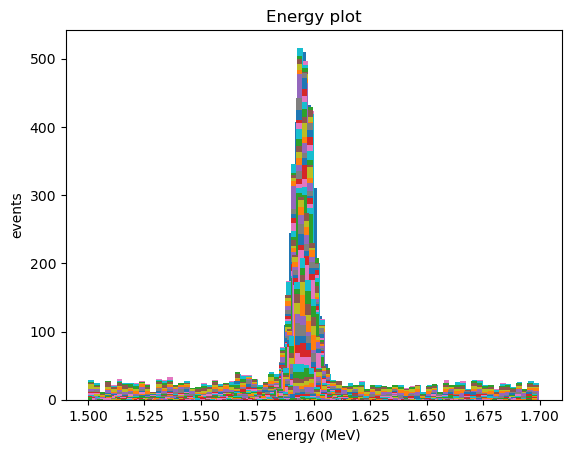

In [98]:
fixed_fom_out = fom_calc_MC_sigonlyfit(cut_tracks, pos_events, cut_list,)

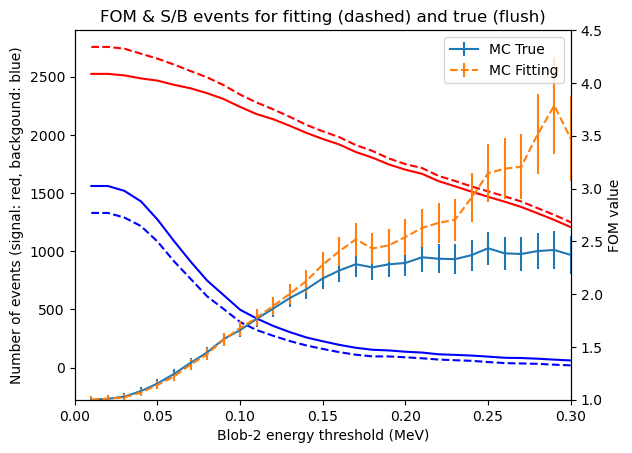

In [106]:
fig, ax1 = plt.subplots()

ax1.plot(cut_list, ns[:-1], label = "Signal events - MC TRUE", color = 'red')
ax1.plot(cut_list, nb[:-1], label = "Background events - MC TRUE", color = 'blue')
ax1.plot(cut_list, fixed_fom_out[2][:-1], label = "Signal events - MC FIT", linestyle = 'dashed', color = 'red')
ax1.plot(cut_list, fixed_fom_out[3][:-1], label = "Background events - MC FIT", linestyle = 'dashed', color = 'blue')

ax2 = ax1.twinx()

ax2.errorbar(cut_list, fom, yerr = fom_erro, label = "MC True")
ax2.errorbar(cut_list, fixed_fom_out[0], yerr = fixed_fom_out[1], label = "MC Fitting", linestyle = 'dashed')
ax2.set_ylim([1, 4.5])

plt.xlim([0, 0.3])
ax1.set_ylabel("Number of events (signal: red, backgound: blue)")
ax2.set_ylabel("FOM value")
ax1.set_xlabel("Blob-2 energy threshold (MeV)")
ax2.legend()
plt.title("FOM & S/B events for fitting (dashed) and true (flush)")
plt.show()

Text(0.5, 1.0, 'FOM - Nb controlled by Ns (fixed) and not')

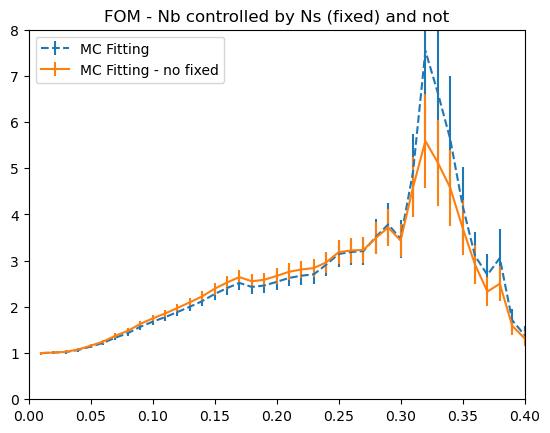

In [109]:
plt.errorbar(cut_list, fixed_fom_out[0], yerr = fixed_fom_out[1], label = "MC Fitting", linestyle = 'dashed')
plt.errorbar(cut_list, fom_out[0], yerr = fom_out[1], label = "MC Fitting - no fixed", linestyle = 'solid')
plt.legend()
plt.xlim([0,0.4])
plt.ylim([0,8])
plt.title('FOM - Nb controlled by Ns (fixed) and not')